# Setup

In [1]:
# Standard library imports
from datetime import datetime, timedelta
from io import BytesIO
import os
import sys
import urllib.parse

# Third-party imports
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.utils import resample
import pmdarima as pm

# Modify the path to include the parent directory for module imports
if '__file__' in globals():
    current_dir = os.path.dirname(os.path.abspath(__file__))
else:
    current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

# Local application/library specific imports
from modules.handlers import DataHandler
from modules.news_api import NewsAPI
from modules.useconomyapi import USEconomyAPI
from modules.seekingalpha import SeekingAlphaNewsAPI
from modules.visualizations import Visualizations
from modules.cryptopanic import CryptoPanicAPI
from modules.cryptonewsapi import CryptoNewsAPI
from modules.coinrankingapi import CryptoDataFetcher
from modules.sentiment import SentimentAnalyzer

# Initialize objects from local modules
hd = DataHandler()
vz = Visualizations()


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def analysis(combined_data, from_date, model_type='linear', for_web=False, predict_days=7, tune=None):
    config = {
        1: {'time': '5min', 'period': 'Per 5 Minute', 'intervals': '30min', 'lags': [-10, -5, -1, 0, 1, 5, 10]},
        2: {'time': 'Day', 'period': 'Daily', 'intervals': 'W', 'lags': [-7, -2, -1, 0, 1, 2, 7]},
        30: {'time': 'Day', 'period': 'Daily', 'intervals': 'W', 'lags': [-7, -2, -1, 0, 1, 2, 7]}
    }

    time = config[from_date]['time']
    period = config[from_date]['period']
    intervals = config[from_date]['intervals']
    lags = config[from_date]['lags']
    colors = plt.cm.viridis(np.linspace(0, 1, 10))
    results = []
    future_predictions_by_lag = []
    correlations = []

    for lag in lags:
        temp_data = combined_data.copy()
        temp_data['Lagged Sentiment'] = temp_data['average sentiment'].shift(lag)
        temp_data.dropna(inplace=True)

        if temp_data.empty or len(temp_data) < 4:
            print(f"Not enough data points to perform fit for lag {lag}")
            continue

        correlation = temp_data[['Lagged Sentiment', f'Next {time} Price Change']].corr().iloc[0, 1]
        correlations.append((lag, correlation))
        
        X = temp_data[['Lagged Sentiment']]
        y = temp_data[f'Next {time} Price Change']

        # Split the data into training and testing sets (75% training, 25% testing)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # Initialize the appropriate model
        if model_type == 'linear':
            X_train = sm.add_constant(X_train)
            X_test = sm.add_constant(X_test)
            model = sm.OLS(y_train, X_train).fit()
        elif model_type == 'gbm':
            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
            model.fit(X_train, y_train)
        elif model_type == 'svr':
            model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
            model.fit(X_train, y_train)
        else:
            if tune == 'yes':
                model = GridSearchCV(
                    RandomForestRegressor(random_state=42),
                    param_grid={
                        'n_estimators': [100, 500, 1000],
                        'max_depth': [None, 10, 20, 30],
                        'min_samples_split': [2, 5, 10]
                    },
                    cv=5, scoring='neg_mean_squared_error', verbose=0
                )
            else:
                model = RandomForestRegressor(n_estimators=1000, random_state=42)
            model.fit(X_train, y_train)

        # Predict and calculate metrics on the test set
        y_pred = model.predict(X_test)
        rsquared = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append({
            "correlation": round(correlation, 2),
            "rsquared": round(rsquared, 2),
            "rmse": round(rmse, 2),
            "lag": lag
        })

        # Future predictions for the last few days as per predict_days
        future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
        if not future_sentiment.isna().any():
            future_pred = model.predict(np.atleast_2d(future_sentiment).T if model_type != 'linear' else sm.add_constant(future_sentiment))
            future_predictions_by_lag.append(future_pred.mean(axis=0))
        else:
            print("Skipping prediction due to NaN values in input")


        # Visualization and further output
        if for_web:
            fig, ax = plt.subplots(figsize=(8, 6))
            scatter = ax.scatter(temp_data['Lagged Sentiment'], temp_data[f'Next {time} Price Change'], 
                                c=temp_data[f'Next {time} Price Change'], cmap='viridis')
            plt.title(f'{period} Sentiment vs. Lag {lag} Price Change')
            plt.xlabel('Lagged Sentiment')
            plt.ylabel(f'Next {time} Price Change')
            plt.grid(True)
            m, b = np.polyfit(temp_data['Lagged Sentiment'], temp_data[f'Next {time} Price Change'], 1)
            plt.plot(temp_data['Lagged Sentiment'], m * temp_data['Lagged Sentiment'] + b, color='darkred')
            img = BytesIO()
            plt.savefig(img, format='svg', bbox_inches='tight')
            img.seek(0)
            svg_data = img.getvalue().decode('utf-8')
            svg_url = "data:image/svg+xml;utf8," + urllib.parse.quote(svg_data)
            plt.close()

            stats = {
                "correlation": round(correlation, 2),
                "average_price_change_high": round(temp_data[temp_data['average sentiment'] > temp_data['average sentiment'].median()][f'Next {time} Price Change'].mean(), 2),
                "average_price_change_low": round(temp_data[temp_data['average sentiment'] <= temp_data['average sentiment'].median()][f'Next {time} Price Change'].mean(), 2),
                "rsquared": round(rsquared, 2),
                "rmse": round(rmse, 2)
            }

            results.append({"plot_url": svg_url, "stats": stats, "lag": lag})
        else:
            plt.scatter(temp_data['Lagged Sentiment'], temp_data[f'Next {time} Price Change'], 
                        c=temp_data[f'Next {time} Price Change'], cmap='viridis')
            plt.title(f'{period} Sentiment vs. Lag {lag} Price Change')
            plt.xlabel('Lagged Sentiment')
            plt.ylabel(f'Next {time} Price Change')
            plt.grid(True)
            m, b = np.polyfit(temp_data['Lagged Sentiment'], temp_data[f'Next {time} Price Change'], 1)
            plt.plot(temp_data['Lagged Sentiment'], m * temp_data['Lagged Sentiment'] + b, color='darkred')
            plt.show()

            print(f"Correlation with {lag} {time}(s) lag: {round(correlation, 2)}")
            print(f"{model_type.capitalize()} Model R-squared: {round(rsquared, 2)}")
            print(f"{model_type.capitalize()} Model RMSE: {round(rmse, 2)}")

            median_sentiment = temp_data['average sentiment'].median()
            high_sentiment = temp_data[temp_data['average sentiment'] > median_sentiment]
            low_sentiment = temp_data[temp_data['average sentiment'] <= median_sentiment]
            print(f"\nAverage Price Change on High Sentiment {time}s:", round((high_sentiment[f'Next {time} Price Change'].mean()) * 100), "%")
            print(f"Average Price Change on Low Sentiment {time}s:", round((low_sentiment[f'Next {time} Price Change'].mean()) * 100), "%")

    if not for_web:
        correlation_summary = pd.DataFrame(correlations, columns=[f'Lag ({time})', 'Correlation'])
        plt.figure(figsize=(8, 4))
        sns.barplot(x=f'Lag ({time})', y='Correlation', data=correlation_summary, color=colors[0])
        plt.title('Correlation of Sentiment and Price Change Over Different Lags')
        plt.ylabel('Correlation Coefficient')
        plt.xlabel(f'{time}s of Lag')
        plt.show()

    if for_web:
        return results, future_predictions_by_lag
    else:
        return future_predictions_by_lag


# Historical BTC

## August 2024

2023-08-04 2023-09-02
Incorrect date format found in rows:
                      date                                           headline  \
30606    2022-01-12 00:00  Republic of Palau and Cryptic Labs launch digi...   
30619    2022-01-11 00:00  Ethereum futures and options data reflects tra...   
30693  2021-12-9 21:00:00  Lack of Transparency Blighting El Salvador's B...   
30694  2021-12-9 18:16:00  Polygon Makes USD 400M Bet On Ethereum Scaling...   
30695  2021-12-9 17:34:00  Bitcoin Hashrate Close to Full Recovery After ...   
...                   ...                                                ...   
30888  2021-11-3 11:36:00  Ethereum Name Service to Pass Governance Over ...   
30889  2021-11-3 10:41:00  Ethereum Futures ETF May Come Before Spot Bitc...   
30945  2021-11-2 19:00:00  CryptoPunk Mistakenly Sells at Over 99% Discou...   
30946  2021-11-2 15:07:00  SCRT Rallies As Quentin Tarantino Releases NFT...   
31030  2021-11-1 15:18:00  Google's Parent Increases its Cry

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\modules\visualizations.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d %H:%M:%S")


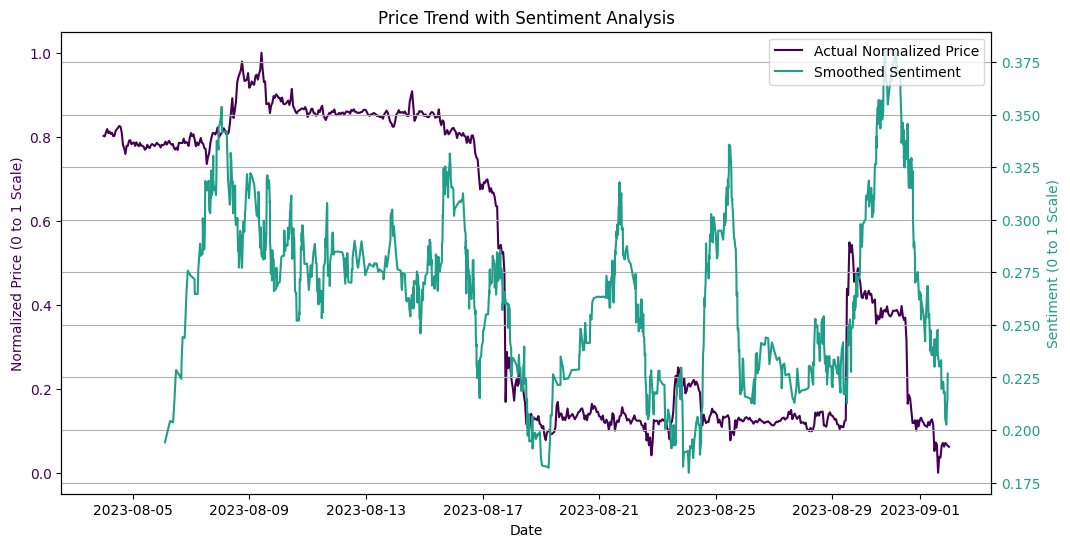

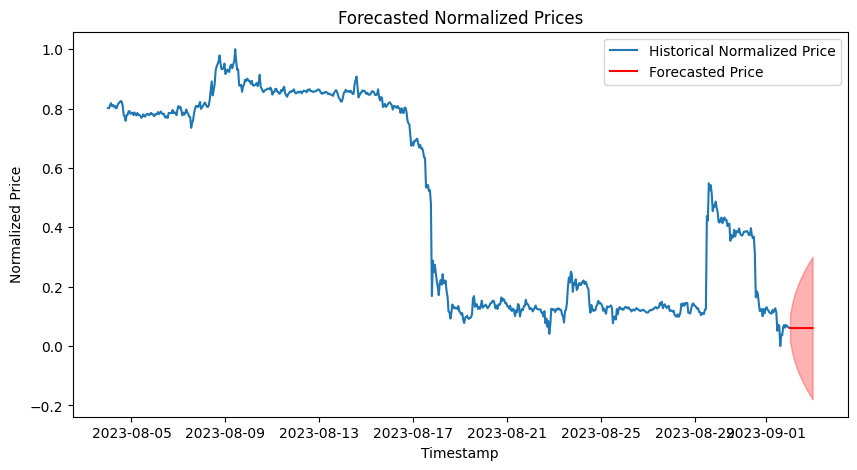

{'average_change_percent': -1.2693329951082184, 'average_ci_lower_percent': -265.7057716131504, 'average_ci_upper_percent': 263.167105622934, 'rmse': 0.19675953651940117}


In [4]:
sentiment_data = pd.read_csv(f"../data/ADA_df/testing_news_with_sentiment_data.csv")
price_data = pd.read_csv(f"../data/ADA_df/testing_price_data.csv")
from_date = 0
end = hd.get_date_str(265)
start = hd.get_date_str(294)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())

# Filter the data for the specified date range
price_data = price_data[(price_data['timestamp'] >= start_timestamp) & (price_data['timestamp'] <= end_timestamp)]
vz.window_size = 70
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end, start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)
averages_forecasts, plot = vz.forecast_prices_with_arima(price_data, forecast_periods=24, for_web=False)
print(averages_forecasts)
# Resample sentiment data to hourly frequency, taking the mean sentiment for each hour
sentiment_data_hourly = sentiment_data.resample('D').mean()
price_data_daily = price_data.resample('D').mean()  # Consider changing this if alignment issues are suspected

# Merge the datasets on the hourly timestamp
combined_data = pd.merge(
    price_data,
    sentiment_data_hourly,
    left_index=True,
    right_index=True,
    how='inner'
)


epsilon = 0.01  # Adjust this value based on the minimum expected non-zero price
combined_data['Next Day Price Change'] = (
    (combined_data['normalized price'].shift(-1) - combined_data['normalized price']) /
    (combined_data['normalized price'] + epsilon)
) * 100

combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data.dropna(inplace=True)


### Linear

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_33688\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Skipping prediction due to NaN values in input


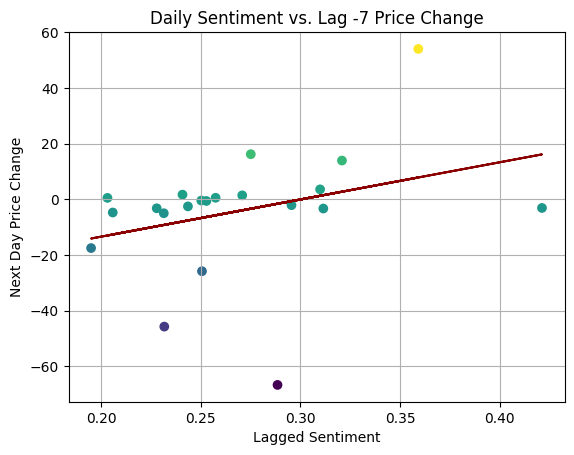

Correlation with -7 Day(s) lag: 0.32
Linear Model R-squared: -2.02
Linear Model RMSE: 12.05

Average Price Change on High Sentiment Days: -9 %
Average Price Change on Low Sentiment Days: -807 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_33688\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


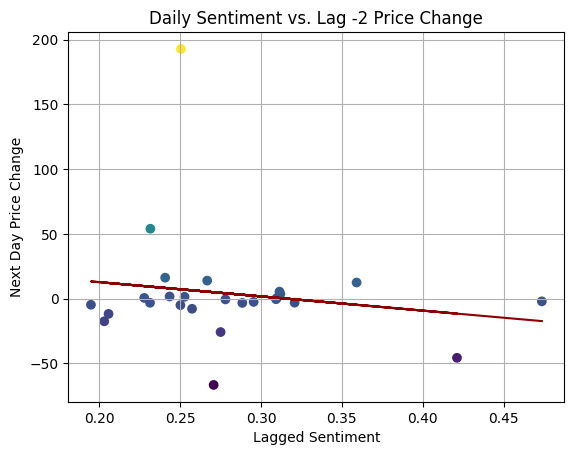

Correlation with -2 Day(s) lag: -0.16
Linear Model R-squared: -1.01
Linear Model RMSE: 34.34

Average Price Change on High Sentiment Days: 1347 %
Average Price Change on Low Sentiment Days: -568 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_33688\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


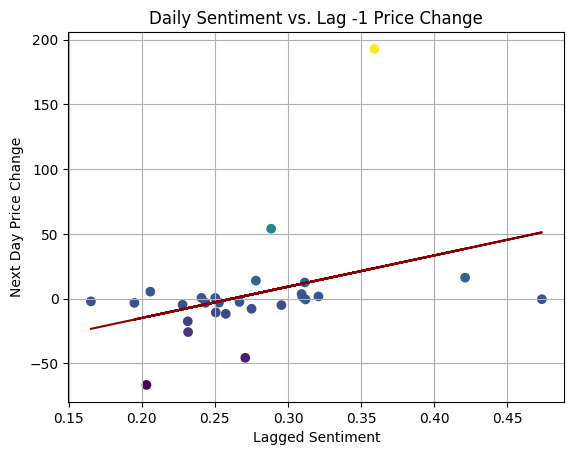

Correlation with -1 Day(s) lag: 0.37
Linear Model R-squared: -0.06
Linear Model RMSE: 23.31

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -564 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_33688\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


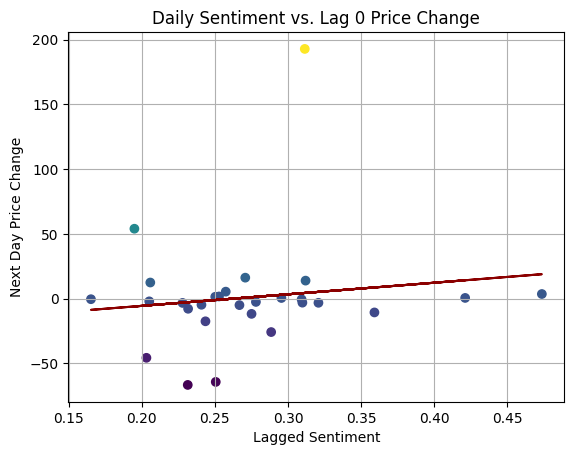

Correlation with 0 Day(s) lag: 0.13
Linear Model R-squared: -0.16
Linear Model RMSE: 75.16

Average Price Change on High Sentiment Days: 1174 %
Average Price Change on Low Sentiment Days: -987 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_33688\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


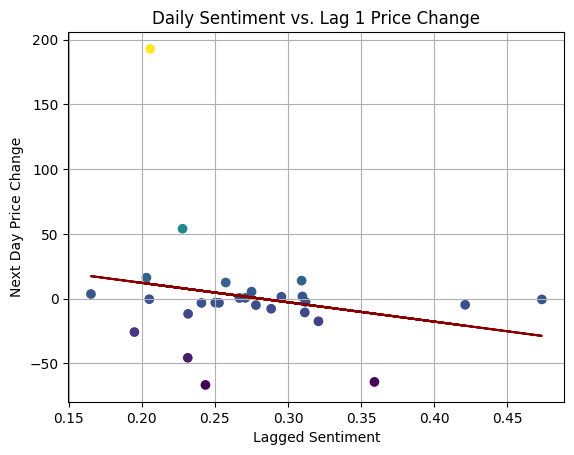

Correlation with 1 Day(s) lag: -0.22
Linear Model R-squared: -2.44
Linear Model RMSE: 28.23

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -1008 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_33688\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


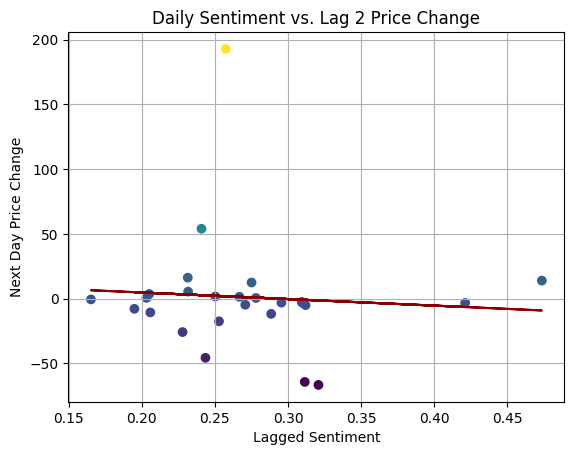

Correlation with 2 Day(s) lag: -0.07
Linear Model R-squared: -0.27
Linear Model RMSE: 27.99

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -1082 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_33688\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


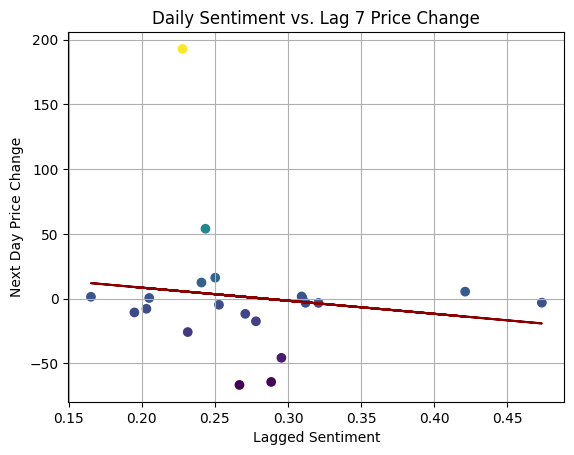

Correlation with 7 Day(s) lag: -0.14
Linear Model R-squared: -0.29
Linear Model RMSE: 13.63

Average Price Change on High Sentiment Days: 1606 %
Average Price Change on Low Sentiment Days: -1282 %


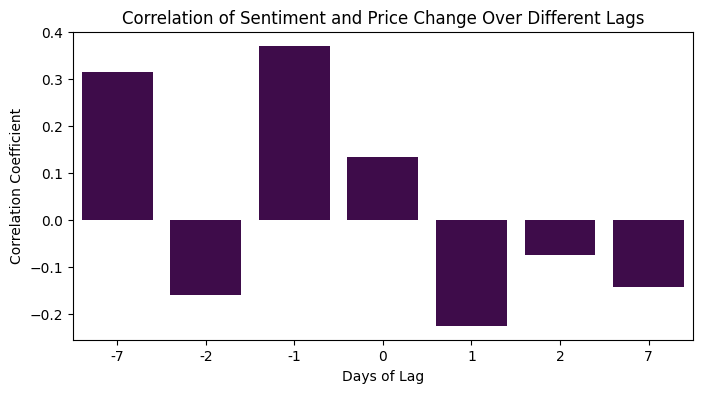

Average Prediction for lag 0: 5.51
Average Prediction for lag 1: 5.81
Average Prediction for lag 2: -6.38
Overall Average Prediction across all lags: 1.65


In [5]:
# Perform Analysis
from_date=30
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### Random Forest

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


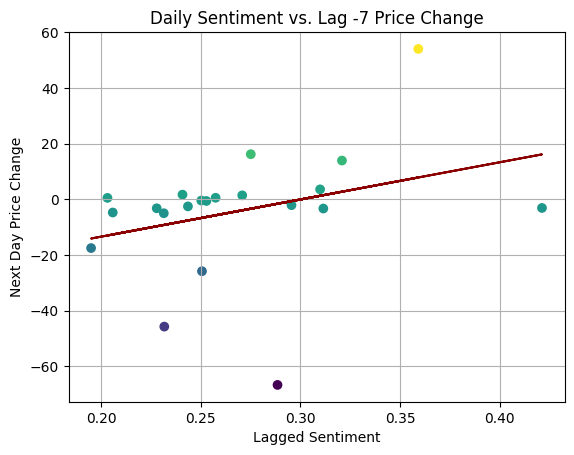

Correlation with -7 Day(s) lag: 0.32
Rf Model R-squared: -18.46
Rf Model RMSE: 30.56

Average Price Change on High Sentiment Days: -9 %
Average Price Change on Low Sentiment Days: -807 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


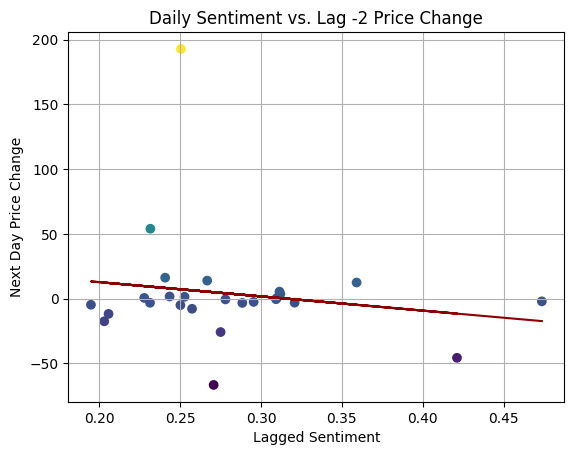

Correlation with -2 Day(s) lag: -0.16
Rf Model R-squared: -4.95
Rf Model RMSE: 59.05

Average Price Change on High Sentiment Days: 1347 %
Average Price Change on Low Sentiment Days: -568 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


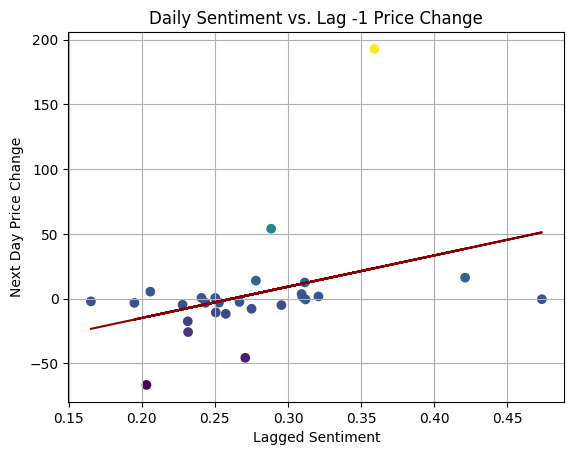

Correlation with -1 Day(s) lag: 0.37
Rf Model R-squared: -0.44
Rf Model RMSE: 27.24

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -564 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


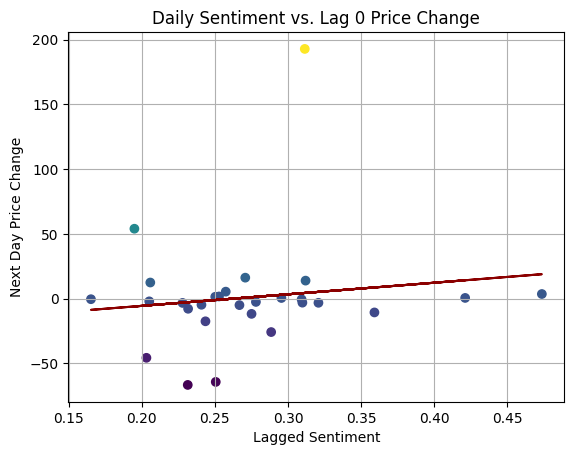

Correlation with 0 Day(s) lag: 0.13
Rf Model R-squared: -0.23
Rf Model RMSE: 77.29

Average Price Change on High Sentiment Days: 1174 %
Average Price Change on Low Sentiment Days: -987 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


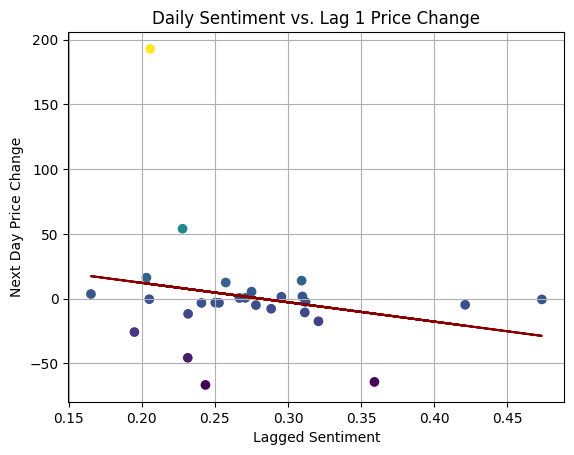

Correlation with 1 Day(s) lag: -0.22
Rf Model R-squared: -14.25
Rf Model RMSE: 59.4

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -1008 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Skipping prediction due to NaN values in input


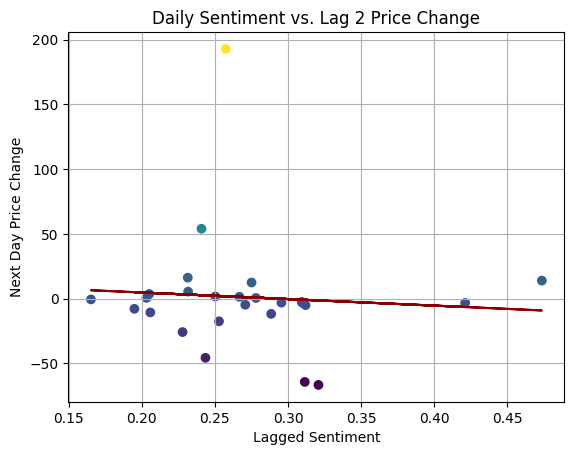

Correlation with 2 Day(s) lag: -0.07
Rf Model R-squared: 0.36
Rf Model RMSE: 19.86

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -1082 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


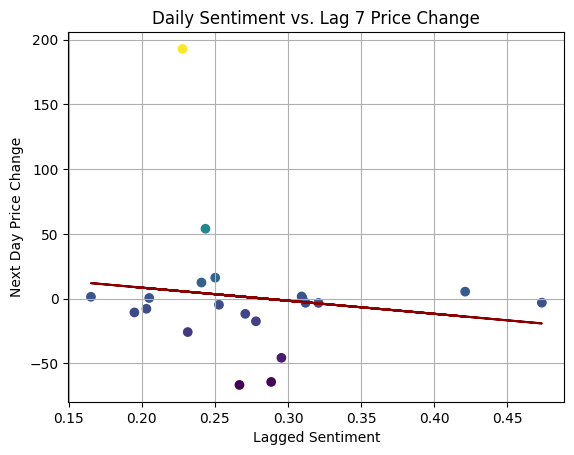

Correlation with 7 Day(s) lag: -0.14
Rf Model R-squared: -4.36
Rf Model RMSE: 27.8

Average Price Change on High Sentiment Days: 1606 %
Average Price Change on Low Sentiment Days: -1282 %


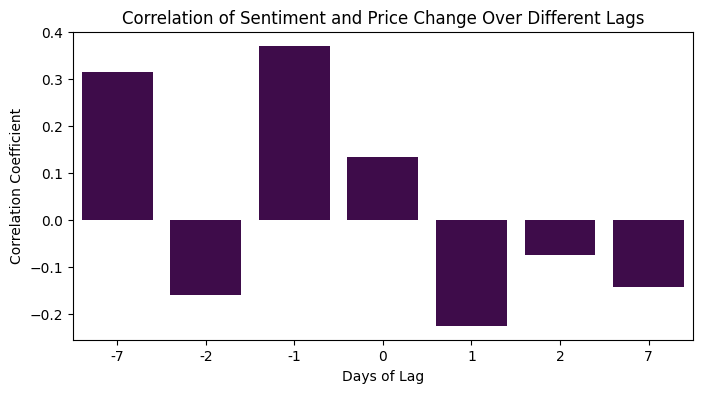

Average Prediction for lag 0: 76.66
Average Prediction for lag 1: 23.56
Average Prediction for lag 2: -8.25
Overall Average Prediction across all lags: 30.66


In [14]:
# Perform Analysis
from_date=30
model_type = 'rf'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### GBM

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


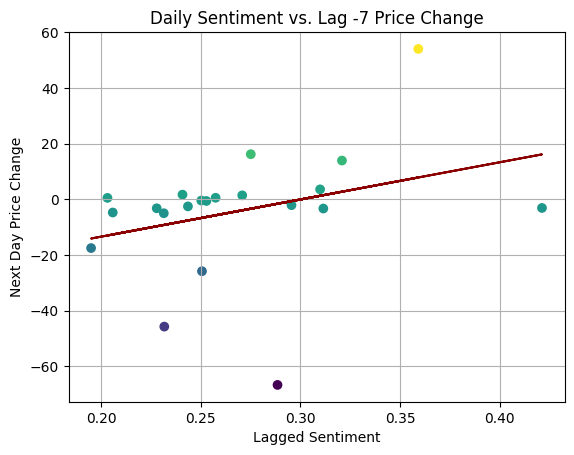

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Correlation with -7 Day(s) lag: 0.32
Gbm Model R-squared: -39.09
Gbm Model RMSE: 43.86

Average Price Change on High Sentiment Days: -9 %
Average Price Change on Low Sentiment Days: -807 %


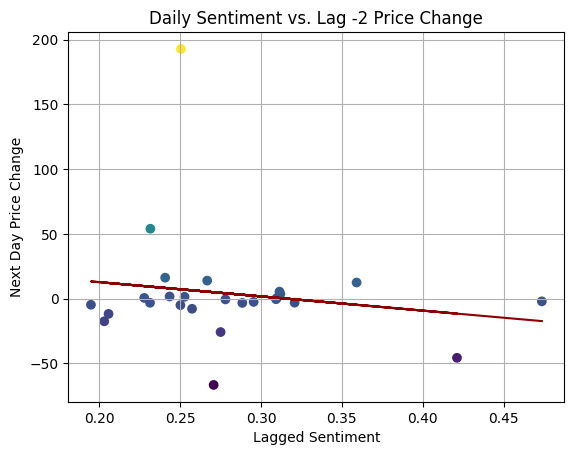

Correlation with -2 Day(s) lag: -0.16
Gbm Model R-squared: -11.29
Gbm Model RMSE: 84.84

Average Price Change on High Sentiment Days: 1347 %
Average Price Change on Low Sentiment Days: -568 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


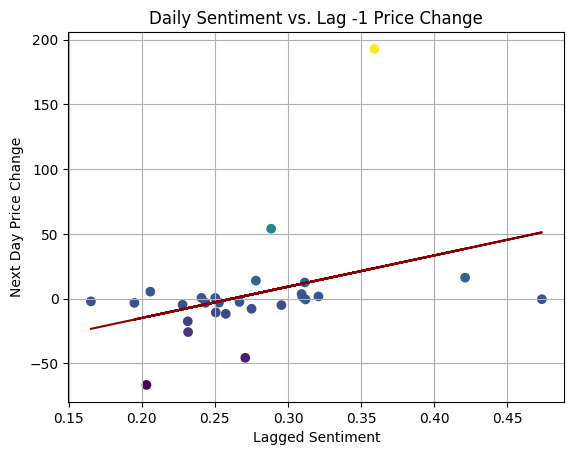

Correlation with -1 Day(s) lag: 0.37
Gbm Model R-squared: -0.76
Gbm Model RMSE: 30.1

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -564 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


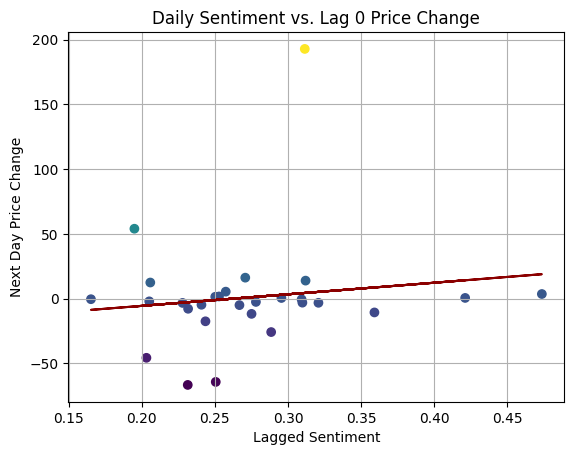

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 0 Day(s) lag: 0.13
Gbm Model R-squared: -0.35
Gbm Model RMSE: 81.1

Average Price Change on High Sentiment Days: 1174 %
Average Price Change on Low Sentiment Days: -987 %
Skipping prediction due to NaN values in input


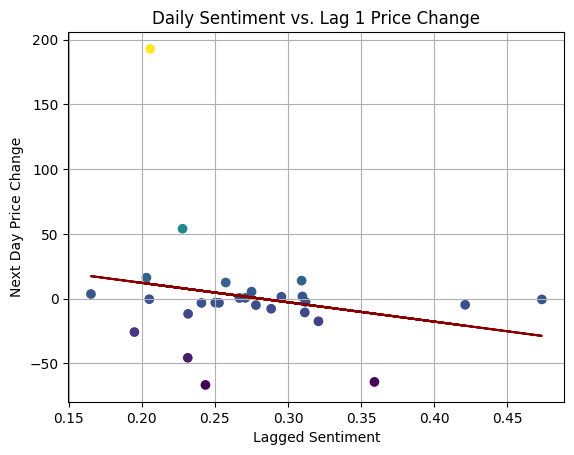

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 1 Day(s) lag: -0.22
Gbm Model R-squared: -30.75
Gbm Model RMSE: 85.71

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -1008 %
Skipping prediction due to NaN values in input


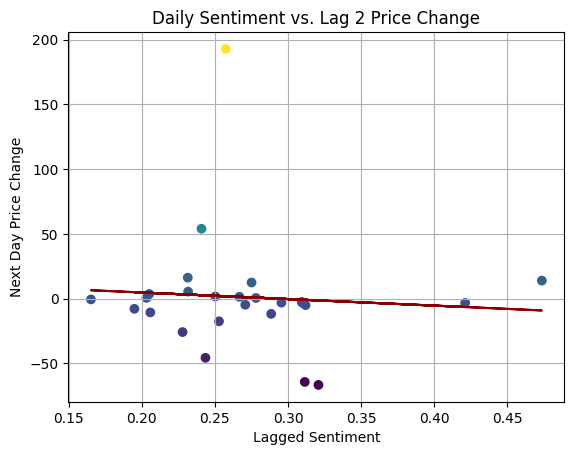

Correlation with 2 Day(s) lag: -0.07
Gbm Model R-squared: -0.09
Gbm Model RMSE: 25.86

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -1082 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Skipping prediction due to NaN values in input


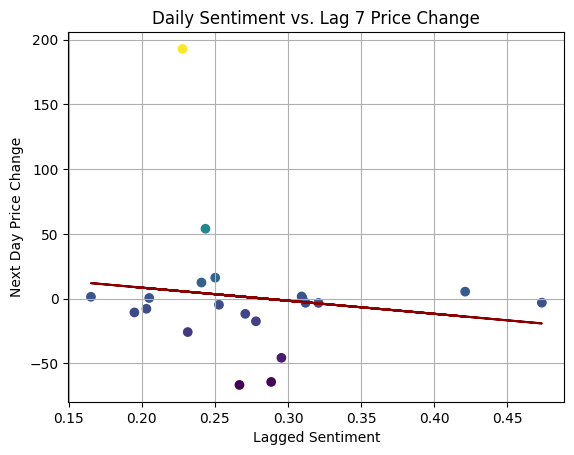

Correlation with 7 Day(s) lag: -0.14
Gbm Model R-squared: -7.59
Gbm Model RMSE: 35.19

Average Price Change on High Sentiment Days: 1606 %
Average Price Change on Low Sentiment Days: -1282 %


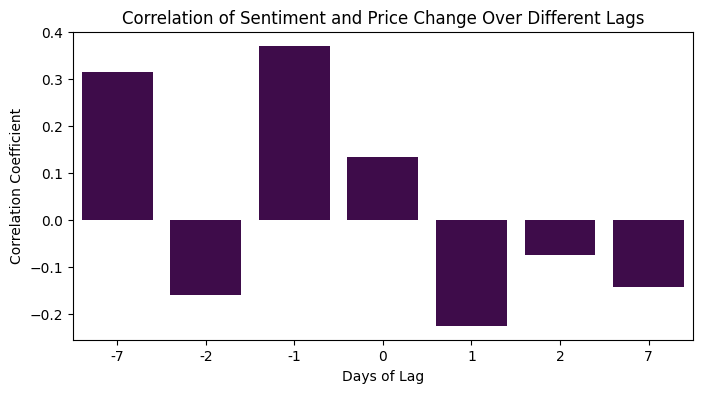

Average Prediction for lag 0: 116.4
Average Prediction for lag 1: 37.63
Average Prediction for lag 2: -8.94
Overall Average Prediction across all lags: 48.36


In [15]:
# Perform Analysis
from_date=30
model_type = 'gbm'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### SVR

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


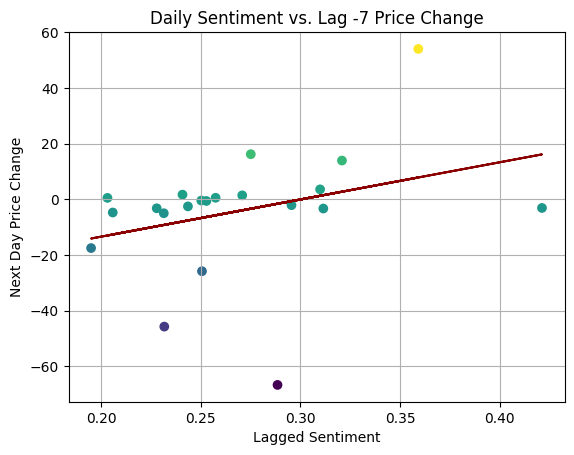

Correlation with -7 Day(s) lag: 0.32
Svr Model R-squared: -0.4
Svr Model RMSE: 8.2

Average Price Change on High Sentiment Days: -9 %
Average Price Change on Low Sentiment Days: -807 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


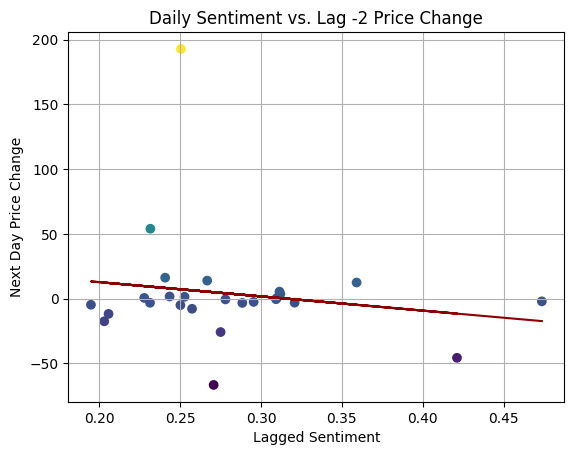

Correlation with -2 Day(s) lag: -0.16
Svr Model R-squared: -0.11
Svr Model RMSE: 25.49

Average Price Change on High Sentiment Days: 1347 %
Average Price Change on Low Sentiment Days: -568 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


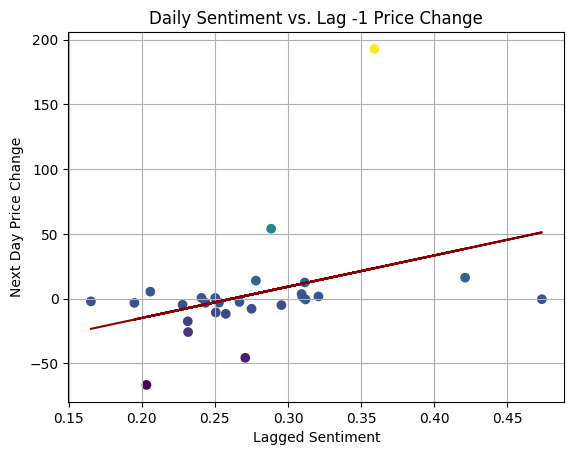

Correlation with -1 Day(s) lag: 0.37
Svr Model R-squared: -0.18
Svr Model RMSE: 24.66

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -564 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


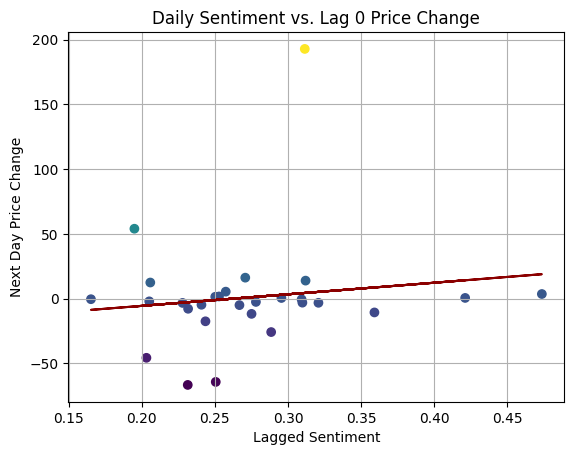

Correlation with 0 Day(s) lag: 0.13
Svr Model R-squared: -0.11
Svr Model RMSE: 73.49

Average Price Change on High Sentiment Days: 1174 %
Average Price Change on Low Sentiment Days: -987 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


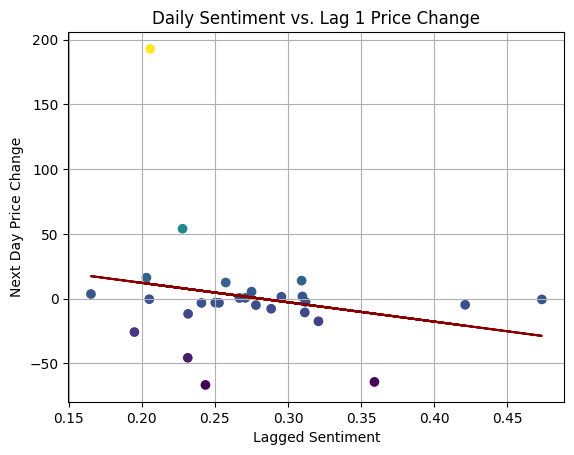

Correlation with 1 Day(s) lag: -0.22
Svr Model R-squared: -0.64
Svr Model RMSE: 19.46

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -1008 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


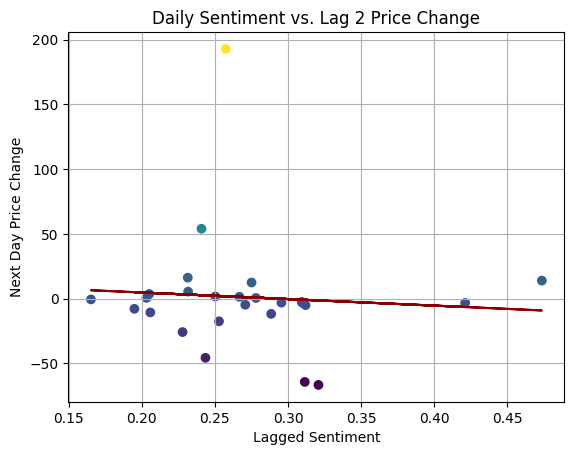

Correlation with 2 Day(s) lag: -0.07
Svr Model R-squared: -0.07
Svr Model RMSE: 25.59

Average Price Change on High Sentiment Days: 1303 %
Average Price Change on Low Sentiment Days: -1082 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


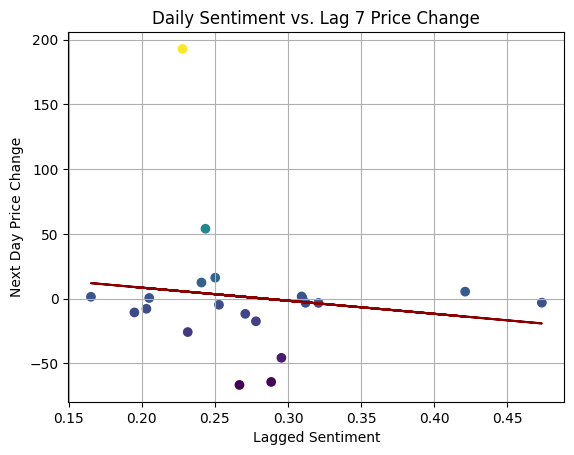

Correlation with 7 Day(s) lag: -0.14
Svr Model R-squared: -0.19
Svr Model RMSE: 13.1

Average Price Change on High Sentiment Days: 1606 %
Average Price Change on Low Sentiment Days: -1282 %


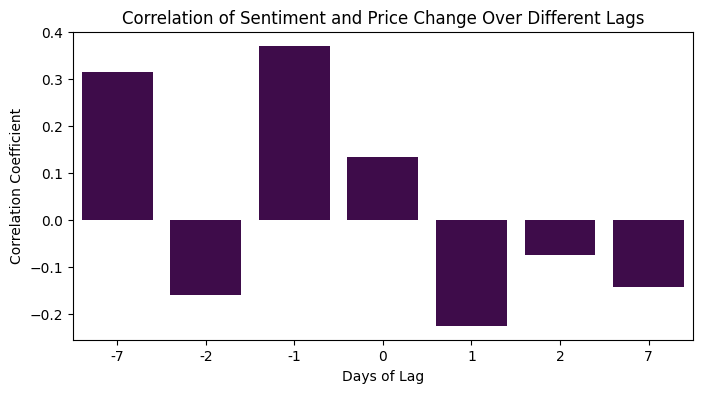

Average Prediction for lag 0: -0.67
Average Prediction for lag 1: -1.39
Average Prediction for lag 2: -0.73
Overall Average Prediction across all lags: -0.93


In [16]:
# Perform Analysis
from_date=30
model_type = 'svr'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

## 01-2022 to 10-2023

2021-10-12 20:00:00 2023-12-19 06:40:41
2022-01-15 2023-10-17
Incorrect date format found in rows:
                      date                                           headline  \
30606    2022-01-12 00:00  Republic of Palau and Cryptic Labs launch digi...   
30619    2022-01-11 00:00  Ethereum futures and options data reflects tra...   
30693  2021-12-9 21:00:00  Lack of Transparency Blighting El Salvador's B...   
30694  2021-12-9 18:16:00  Polygon Makes USD 400M Bet On Ethereum Scaling...   
30695  2021-12-9 17:34:00  Bitcoin Hashrate Close to Full Recovery After ...   
...                   ...                                                ...   
30888  2021-11-3 11:36:00  Ethereum Name Service to Pass Governance Over ...   
30889  2021-11-3 10:41:00  Ethereum Futures ETF May Come Before Spot Bitc...   
30945  2021-11-2 19:00:00  CryptoPunk Mistakenly Sells at Over 99% Discou...   
30946  2021-11-2 15:07:00  SCRT Rallies As Quentin Tarantino Releases NFT...   
31030  2021-11-1 15:

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d %H:%M:%S")


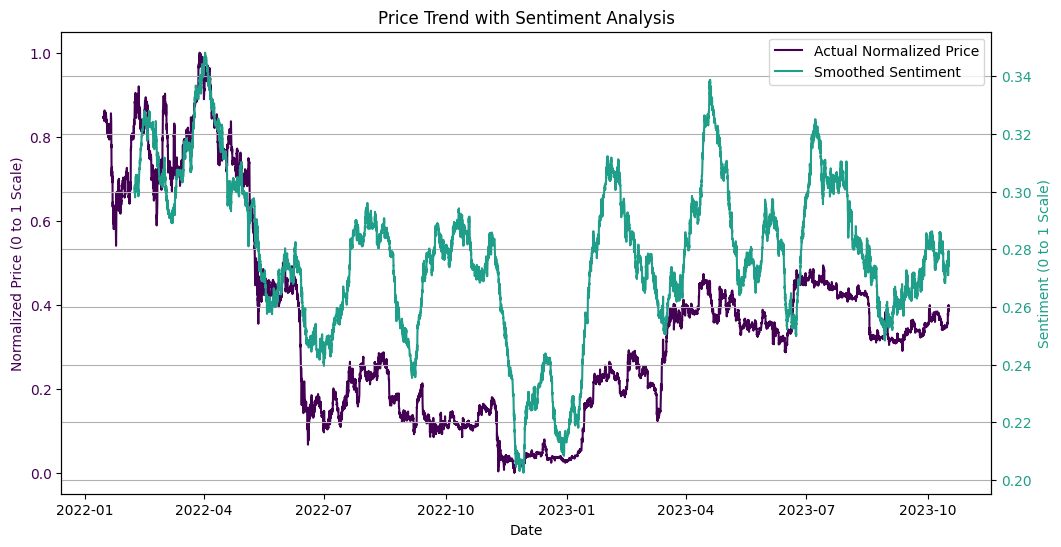

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


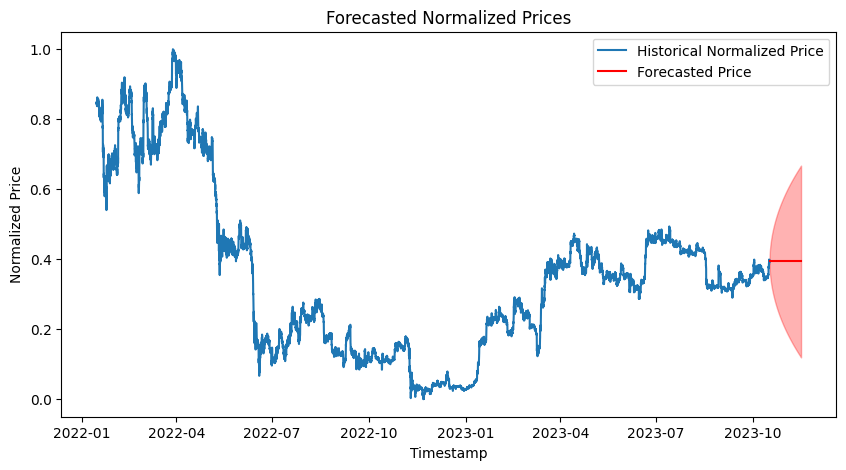

{'average_change_percent': 0.0, 'average_ci_lower_percent': -46.471514327218536, 'average_ci_upper_percent': 46.471514327218536, 'rmse': 0.09264200077724571}


In [17]:
# Load the sentiment data and price data
sentiment_data_path = 'data/ADA_df/testing_news_with_sentiment_data.csv'
sentiment_data = pd.read_csv(sentiment_data_path)
print(sentiment_data['date'].min(),sentiment_data['date'].max())
price_data = pd.read_csv(f"data/ADA_df/testing_price_data.csv")
from_date = 0
end = hd.get_date_str(220)
start = hd.get_date_str(860)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())
# Filter the data for the specified date range
price_data = price_data[(price_data['timestamp'] >= start_timestamp) & (price_data['timestamp'] <= end_timestamp)]

vz.window_size = 800
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end, start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)
averages_forecasts, plot = vz.forecast_prices_with_arima(price_data, forecast_periods=720, for_web=False)
print(averages_forecasts)
# Get the closing price for each day (last price of the day)
price_data_daily = price_data['normalized price'].resample('D').last()

# Calculate the daily price change percentage
price_data_daily = pd.DataFrame(price_data_daily)  # Ensure it's a DataFrame for the next operations
price_data_daily['Price Change'] = price_data_daily['normalized price'].pct_change() * 100

# Shift the price change to align with the day's sentiment to measure its influence on the next day's price change
price_data_daily['Price Change'] = price_data_daily['Price Change'].shift(-1)

# Since sentiment is often recorded multiple times a day, we'll average it for daily granularity
sentiment_data_daily = pd.DataFrame(sentiment_data['average sentiment'].resample('D').mean())

# Merge the two datasets on the date index
combined_data = pd.concat([price_data_daily, sentiment_data_daily], axis=1)
combined_data.columns = ['Normalized Price', 'Next Day Price Change', 'average sentiment']
combined_data.dropna(inplace=True)  # Drop rows with NaN values that might result from resampling, shifting, or non-overlapping dates

### Linear

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


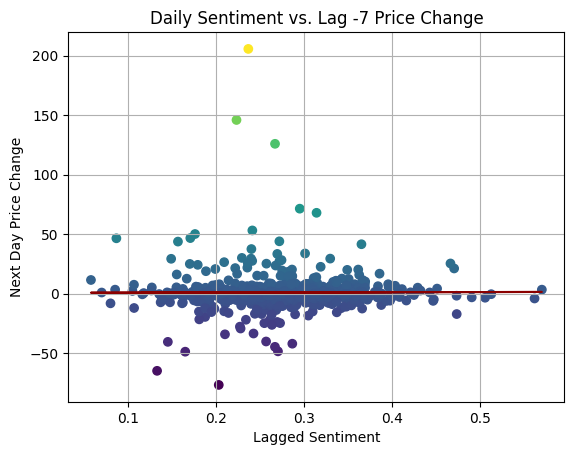

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with -7 Day(s) lag: 0.01
Linear Model R-squared: -0.0
Linear Model RMSE: 20.84

Average Price Change on High Sentiment Days: 62 %
Average Price Change on Low Sentiment Days: 136 %


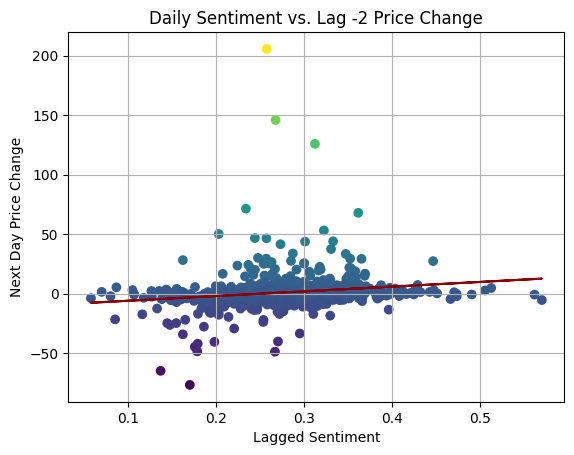

Correlation with -2 Day(s) lag: 0.17
Linear Model R-squared: 0.02
Linear Model RMSE: 20.17

Average Price Change on High Sentiment Days: 61 %
Average Price Change on Low Sentiment Days: 135 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


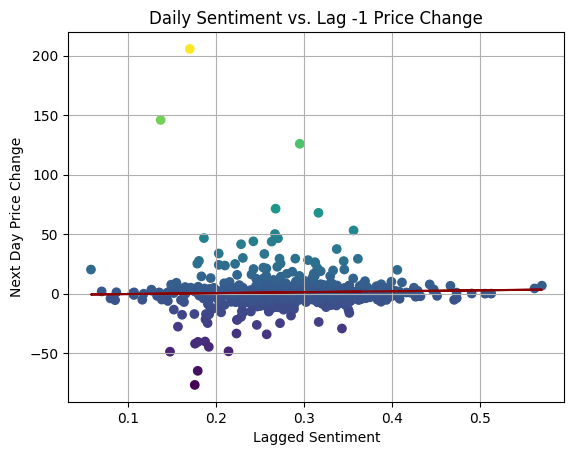

Correlation with -1 Day(s) lag: 0.03
Linear Model R-squared: -0.0
Linear Model RMSE: 13.33

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


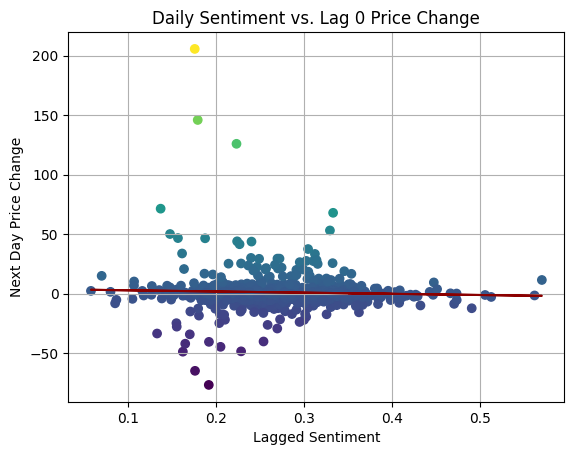

Correlation with 0 Day(s) lag: -0.04
Linear Model R-squared: -0.03
Linear Model RMSE: 23.33

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


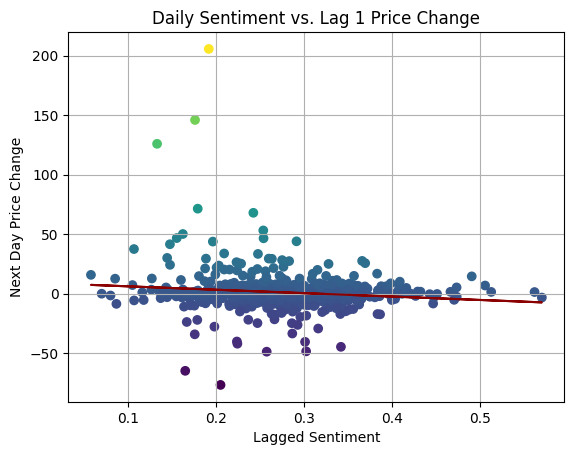

Correlation with 1 Day(s) lag: -0.12
Linear Model R-squared: -0.12
Linear Model RMSE: 12.11

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


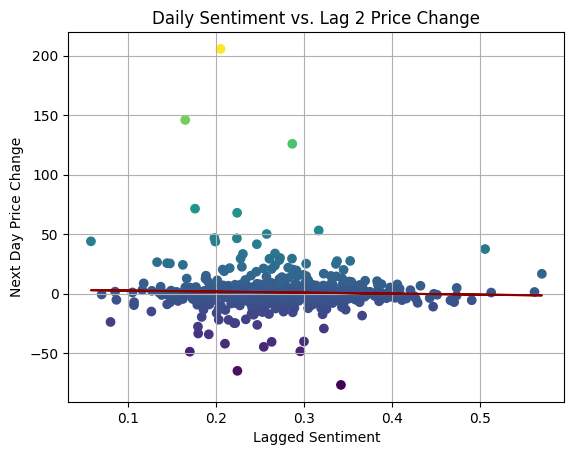

Correlation with 2 Day(s) lag: -0.04
Linear Model R-squared: -0.04
Linear Model RMSE: 10.51

Average Price Change on High Sentiment Days: 65 %
Average Price Change on Low Sentiment Days: 135 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Skipping prediction due to NaN values in input


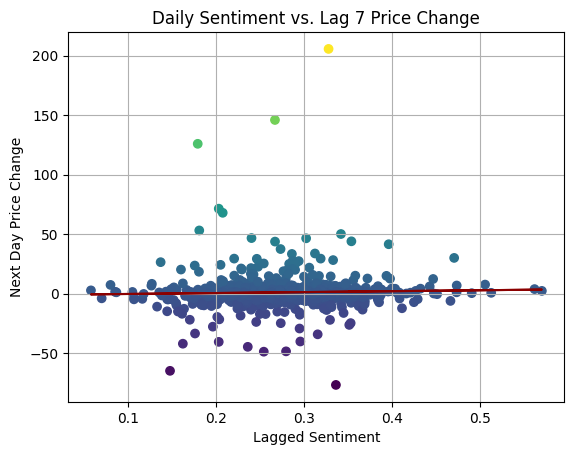

Correlation with 7 Day(s) lag: 0.03
Linear Model R-squared: 0.0
Linear Model RMSE: 21.76

Average Price Change on High Sentiment Days: 77 %
Average Price Change on Low Sentiment Days: 133 %


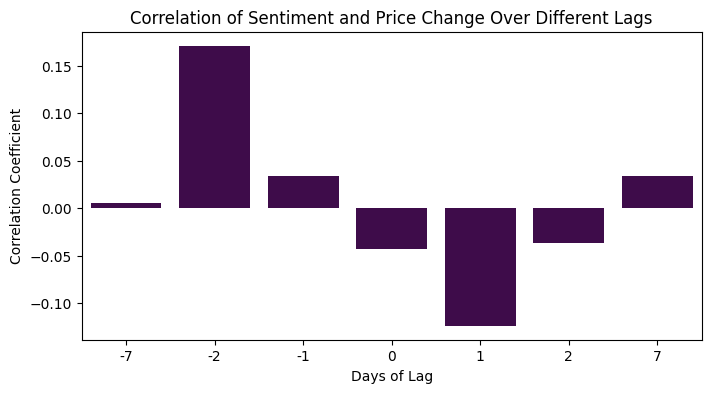

Average Prediction for lag 0: 4.7
Average Prediction for lag 1: 1.07
Average Prediction for lag 2: 0.33
Overall Average Prediction across all lags: 2.03


In [18]:
# Perform Analysis
from_date=30
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### Random Forest

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


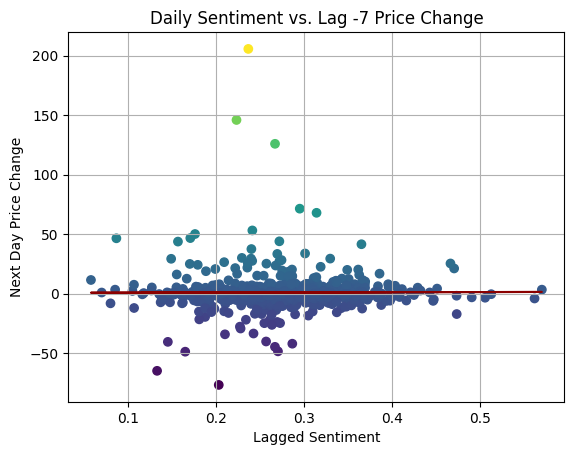

Correlation with -7 Day(s) lag: 0.01
Rf Model R-squared: -0.12
Rf Model RMSE: 22.01

Average Price Change on High Sentiment Days: 62 %
Average Price Change on Low Sentiment Days: 136 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


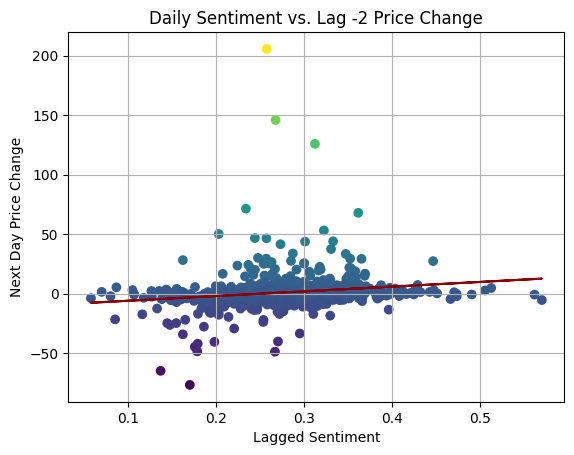

Correlation with -2 Day(s) lag: 0.17
Rf Model R-squared: -0.11
Rf Model RMSE: 21.51

Average Price Change on High Sentiment Days: 61 %
Average Price Change on Low Sentiment Days: 135 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


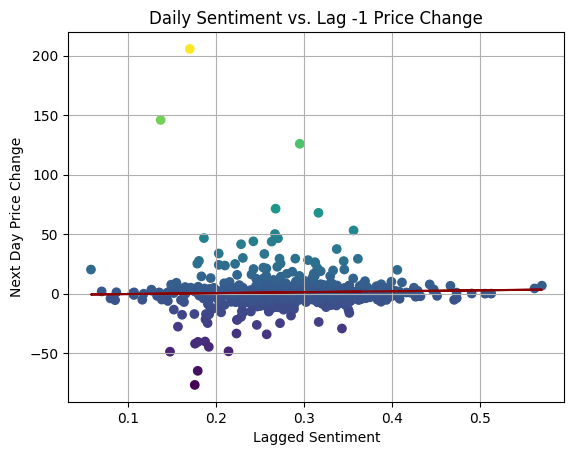

Correlation with -1 Day(s) lag: 0.03
Rf Model R-squared: -0.21
Rf Model RMSE: 14.66

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


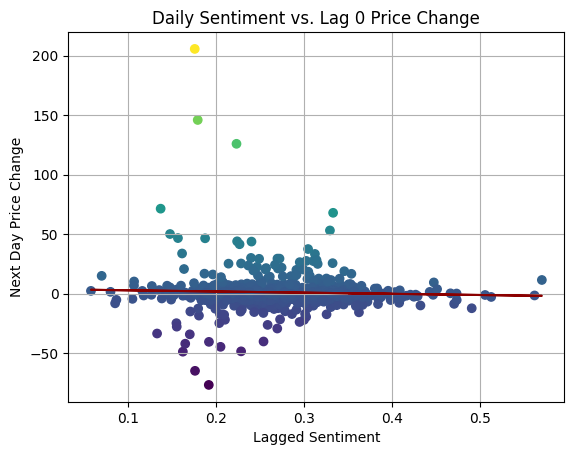

Correlation with 0 Day(s) lag: -0.04
Rf Model R-squared: -0.45
Rf Model RMSE: 27.75

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


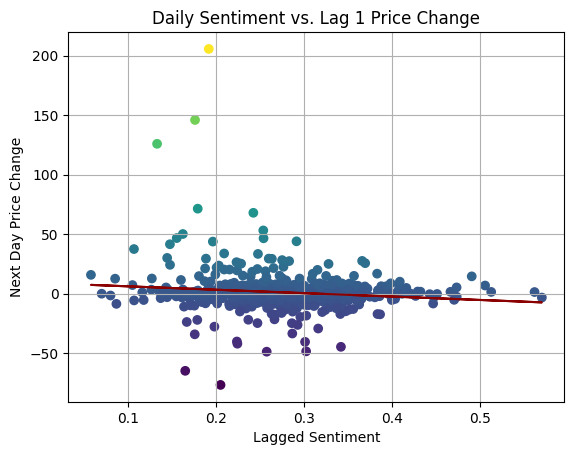

Correlation with 1 Day(s) lag: -0.12
Rf Model R-squared: -1.69
Rf Model RMSE: 18.76

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


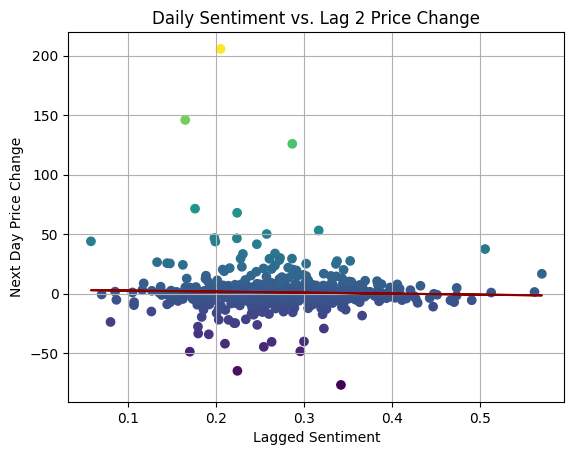

Correlation with 2 Day(s) lag: -0.04
Rf Model R-squared: -1.59
Rf Model RMSE: 16.6

Average Price Change on High Sentiment Days: 65 %
Average Price Change on Low Sentiment Days: 135 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


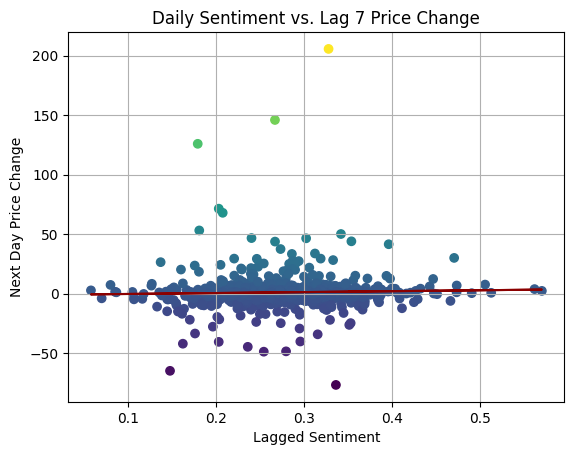

Correlation with 7 Day(s) lag: 0.03
Rf Model R-squared: -0.36
Rf Model RMSE: 25.38

Average Price Change on High Sentiment Days: 77 %
Average Price Change on Low Sentiment Days: 133 %


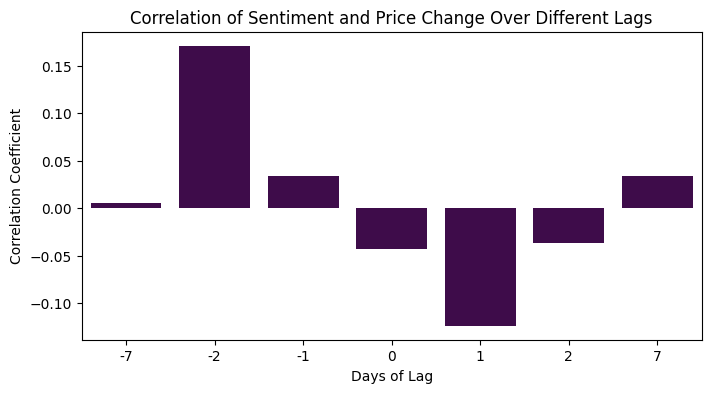

Average Prediction for lag 0: 1.71
Average Prediction for lag 1: 1.19
Average Prediction for lag 2: -0.49
Overall Average Prediction across all lags: 0.8


In [19]:
# Perform Analysis
from_date=30
model_type = 'rf'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### GBM

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


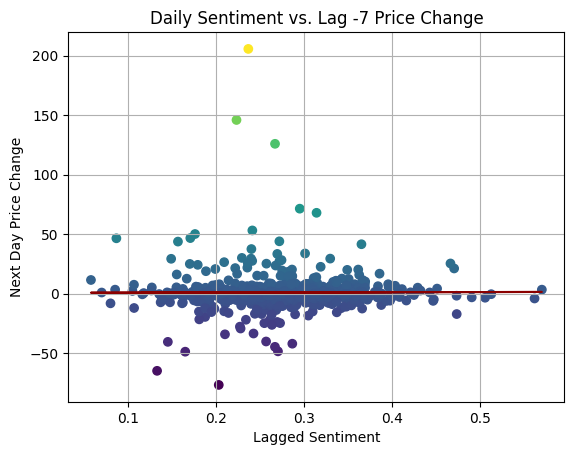

Correlation with -7 Day(s) lag: 0.01
Gbm Model R-squared: -0.06
Gbm Model RMSE: 21.44

Average Price Change on High Sentiment Days: 62 %
Average Price Change on Low Sentiment Days: 136 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


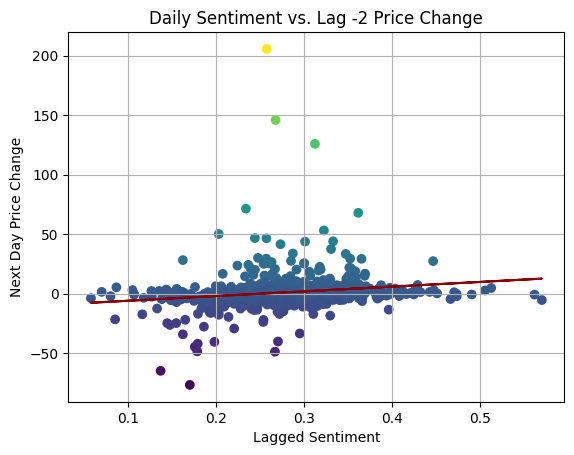

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Correlation with -2 Day(s) lag: 0.17
Gbm Model R-squared: -0.07
Gbm Model RMSE: 21.04

Average Price Change on High Sentiment Days: 61 %
Average Price Change on Low Sentiment Days: 135 %


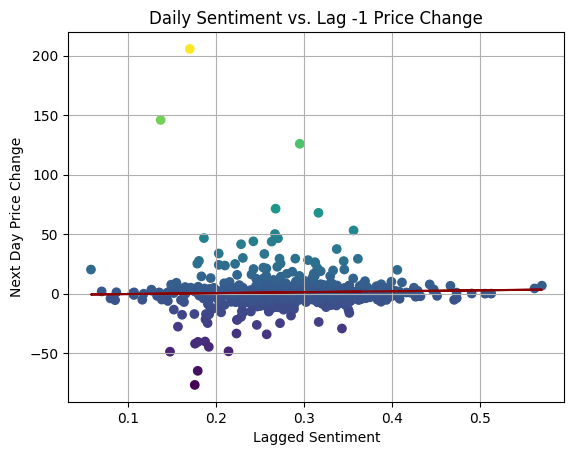

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with -1 Day(s) lag: 0.03
Gbm Model R-squared: -0.01
Gbm Model RMSE: 13.4

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


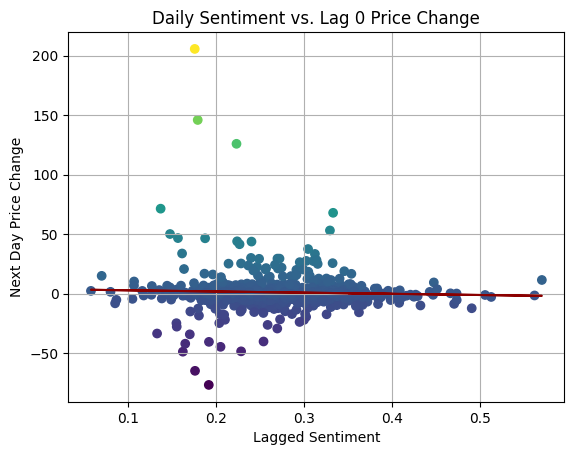

Correlation with 0 Day(s) lag: -0.04
Gbm Model R-squared: -0.38
Gbm Model RMSE: 27.0

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


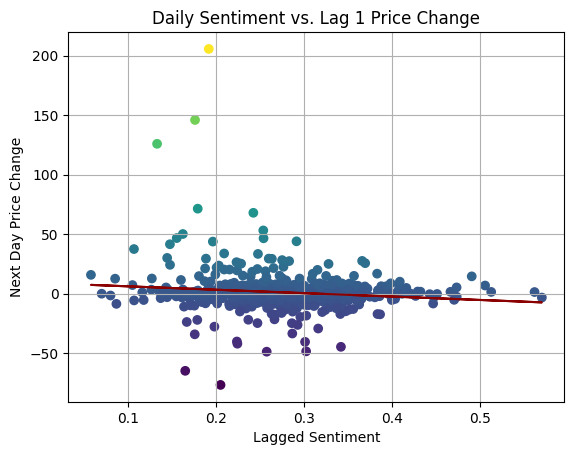

Correlation with 1 Day(s) lag: -0.12
Gbm Model R-squared: -1.97
Gbm Model RMSE: 19.73

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


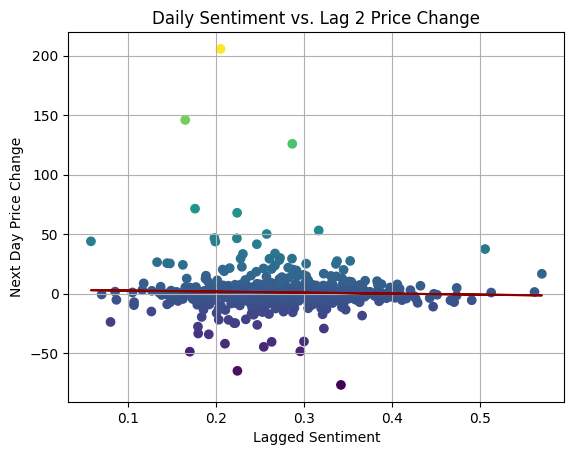

Correlation with 2 Day(s) lag: -0.04
Gbm Model R-squared: -1.34
Gbm Model RMSE: 15.77

Average Price Change on High Sentiment Days: 65 %
Average Price Change on Low Sentiment Days: 135 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


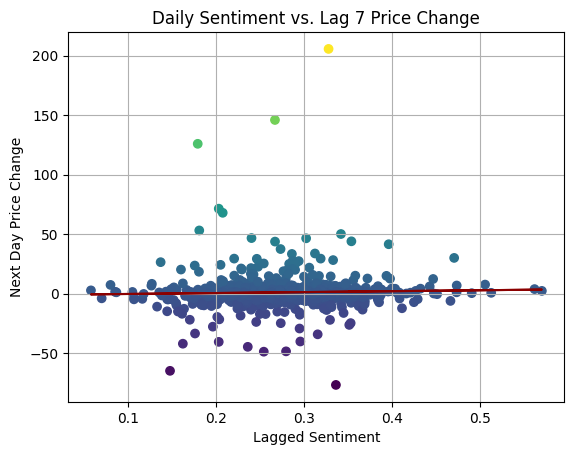

Correlation with 7 Day(s) lag: 0.03
Gbm Model R-squared: -0.37
Gbm Model RMSE: 25.45

Average Price Change on High Sentiment Days: 77 %
Average Price Change on Low Sentiment Days: 133 %


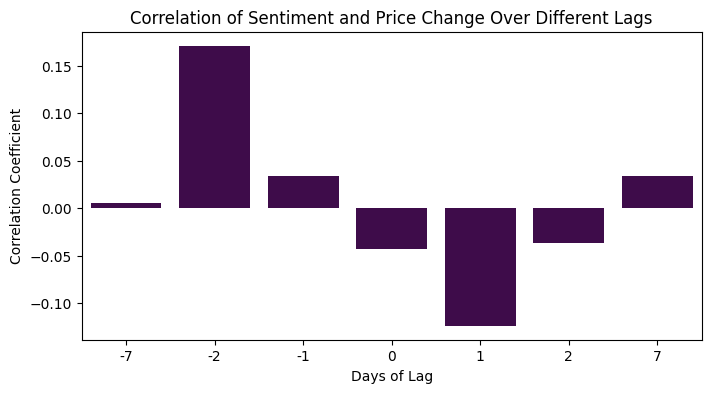

Average Prediction for lag 0: 1.59
Average Prediction for lag 1: -0.35
Average Prediction for lag 2: -0.07
Overall Average Prediction across all lags: 0.39


In [20]:
# Perform Analysis
from_date=30
model_type = 'gbm'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### SVR

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


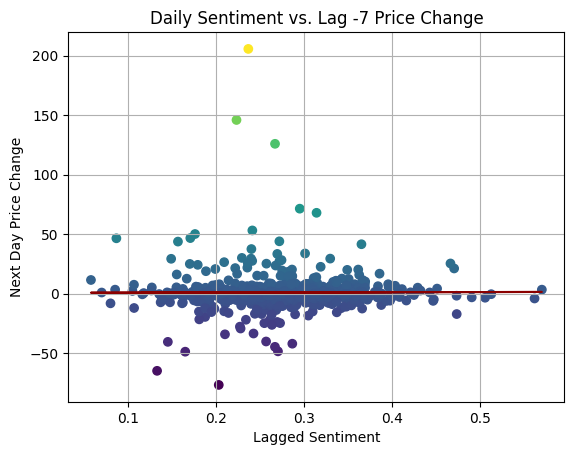

Correlation with -7 Day(s) lag: 0.01
Svr Model R-squared: -0.01
Svr Model RMSE: 20.91

Average Price Change on High Sentiment Days: 62 %
Average Price Change on Low Sentiment Days: 136 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


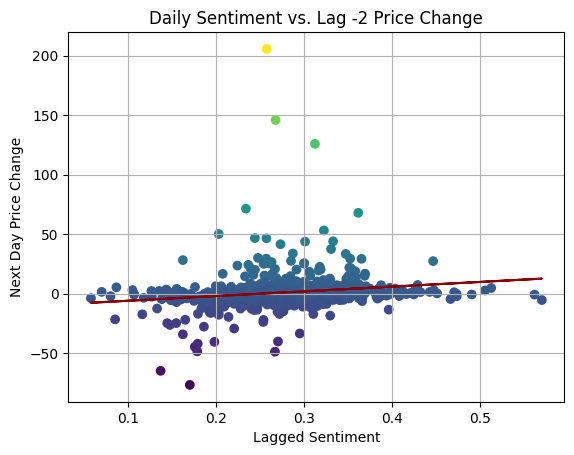

Correlation with -2 Day(s) lag: 0.17
Svr Model R-squared: -0.0
Svr Model RMSE: 20.38

Average Price Change on High Sentiment Days: 61 %
Average Price Change on Low Sentiment Days: 135 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


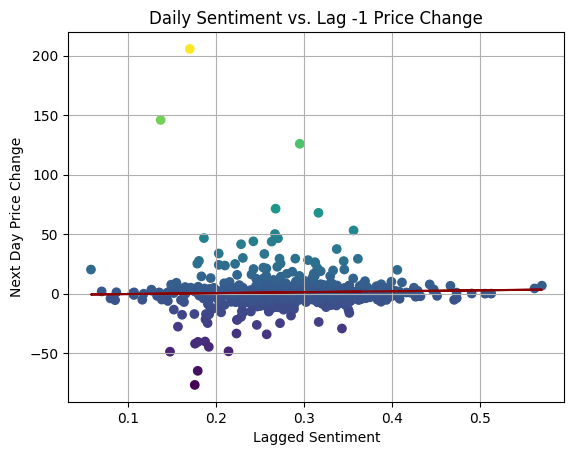

Correlation with -1 Day(s) lag: 0.03
Svr Model R-squared: -0.03
Svr Model RMSE: 13.49

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


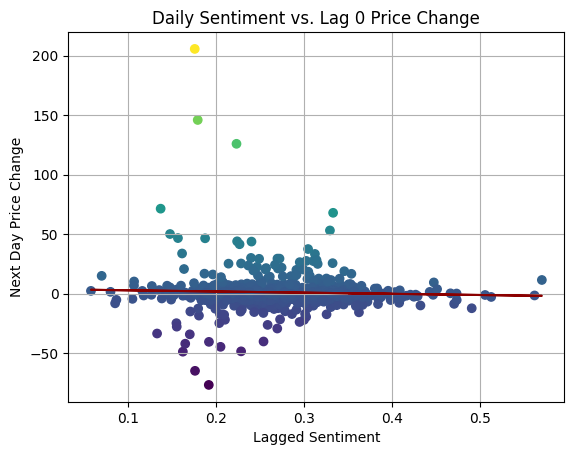

Correlation with 0 Day(s) lag: -0.04
Svr Model R-squared: -0.03
Svr Model RMSE: 23.32

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


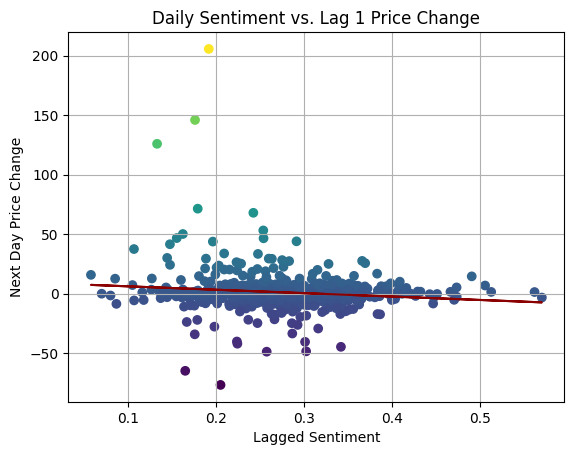

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 1 Day(s) lag: -0.12
Svr Model R-squared: -0.01
Svr Model RMSE: 11.51

Average Price Change on High Sentiment Days: 63 %
Average Price Change on Low Sentiment Days: 136 %
Skipping prediction due to NaN values in input


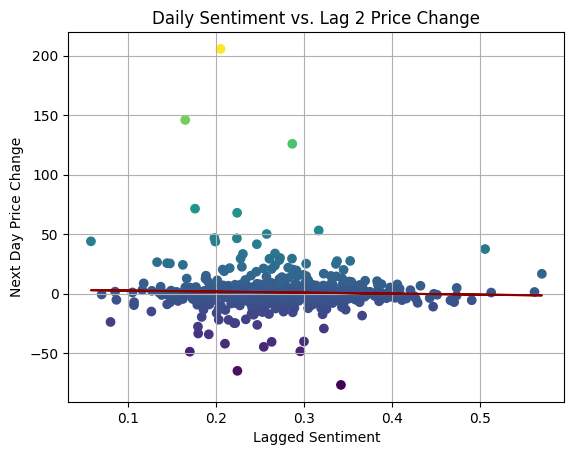

Correlation with 2 Day(s) lag: -0.04
Svr Model R-squared: -0.0
Svr Model RMSE: 10.32

Average Price Change on High Sentiment Days: 65 %
Average Price Change on Low Sentiment Days: 135 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


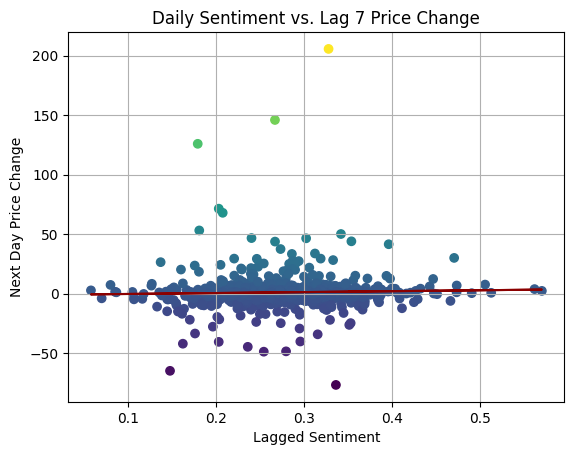

Correlation with 7 Day(s) lag: 0.03
Svr Model R-squared: 0.0
Svr Model RMSE: 21.76

Average Price Change on High Sentiment Days: 77 %
Average Price Change on Low Sentiment Days: 133 %


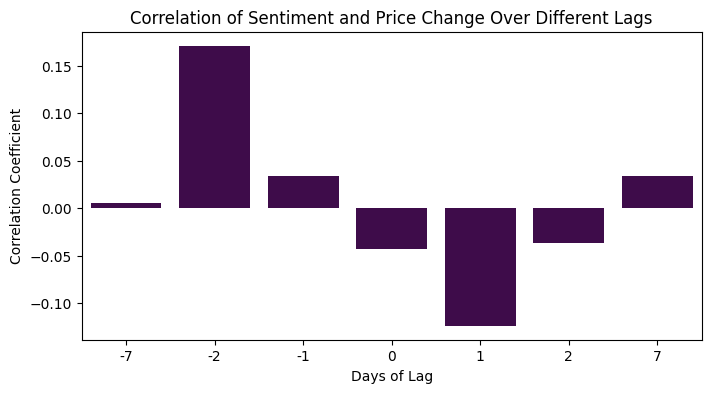

Average Prediction for lag 0: 1.04
Average Prediction for lag 1: -0.24
Average Prediction for lag 2: -0.52
Overall Average Prediction across all lags: 0.09


In [21]:
# Perform Analysis
from_date=30
model_type = 'svr'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

# API DATA

## Monthly

2024-04-18 00:00:00 2024-05-21 00:00:00


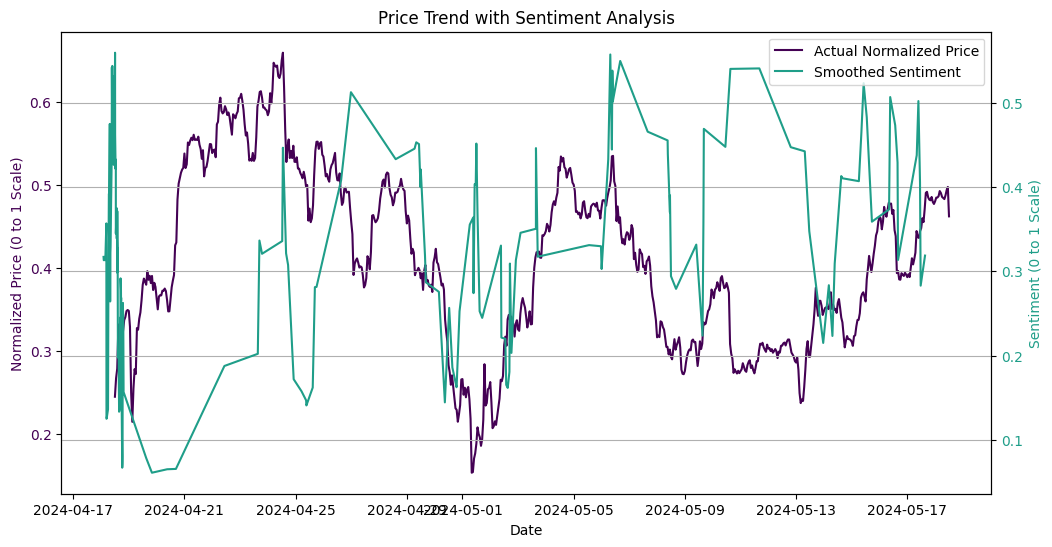

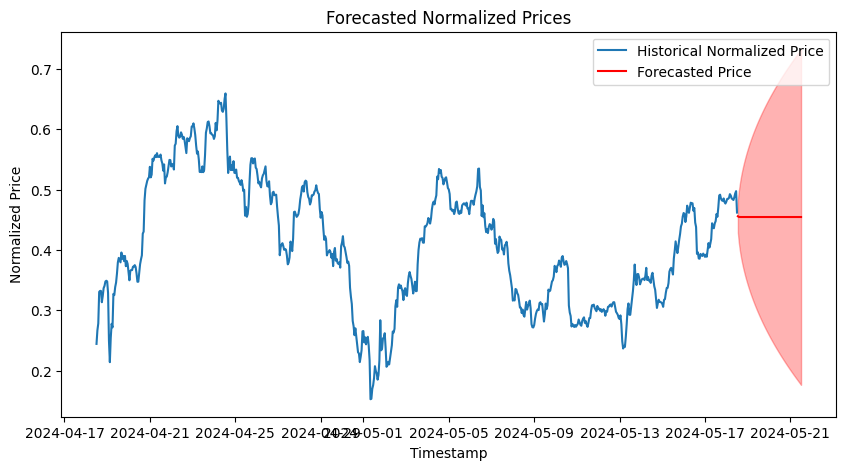

{'average_change_percent': -1.590264992116297, 'average_ci_lower_percent': -41.919322701541354, 'average_ci_upper_percent': 38.73879271730876, 'rmse': 0.1288105628271979}


In [22]:
#for testing purposes
sentiment_data = pd.read_csv(f"data/2024-05-18_30d_news_with_sentiment.csv")
price_data = pd.read_csv('data/2024-05-18_30d_50meme_history.csv')
from_date = 0
end = hd.get_date_dt(3)
start = hd.get_date_dt(36)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())
vz.window_size = 7
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end=end, start=start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)

averages_forecasts, plot = vz.forecast_prices_with_arima(price_data, forecast_periods=72, for_web=False)
print(averages_forecasts)

# Get the closing price for each day (last price of the day)
price_data_daily = price_data['normalized price'].resample('D').last()

# Calculate the daily price change percentage
price_data_daily = pd.DataFrame(price_data_daily)  # Ensure it's a DataFrame for the next operations
price_data_daily['Price Change'] = price_data_daily['normalized price'].pct_change() * 100

# Shift the price change to align with the day's sentiment to measure its influence on the next day's price change
price_data_daily['Price Change'] = price_data_daily['Price Change'].shift(-1)

# Since sentiment is often recorded multiple times a day, we'll average it for daily granularity
sentiment_data_daily = pd.DataFrame(sentiment_data['average sentiment'].resample('D').mean())

# Merge the two datasets on the date index
combined_data = pd.concat([price_data_daily, sentiment_data_daily], axis=1)
combined_data.columns = ['Normalized Price', 'Next Day Price Change', 'average sentiment']
combined_data.dropna(inplace=True)  # Drop rows with NaN values that might result from resampling, shifting, or non-overlapping dates

### Linear

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


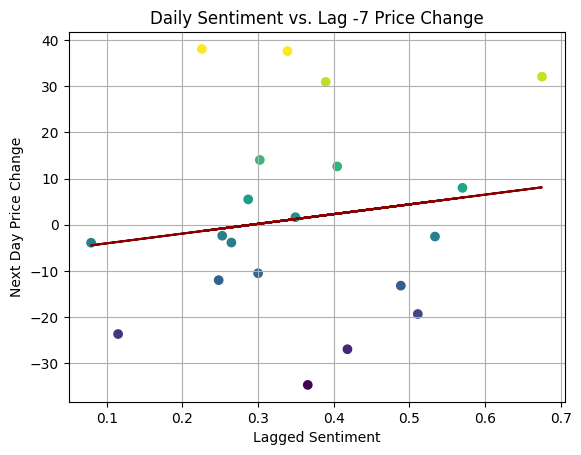

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with -7 Day(s) lag: 0.15
Linear Model R-squared: -0.22
Linear Model RMSE: 28.08

Average Price Change on High Sentiment Days: -580 %
Average Price Change on Low Sentiment Days: 851 %


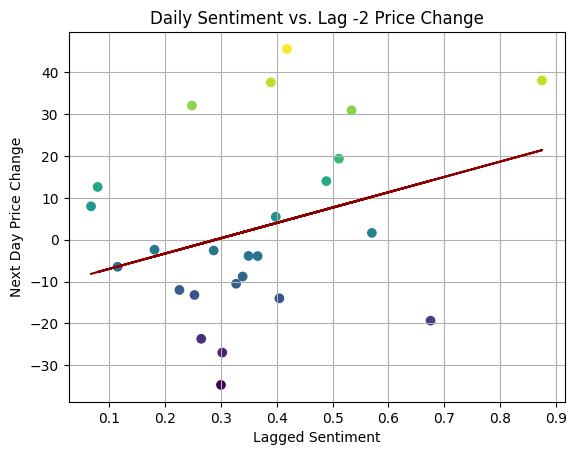

Correlation with -2 Day(s) lag: 0.31
Linear Model R-squared: -0.27
Linear Model RMSE: 29.99

Average Price Change on High Sentiment Days: -220 %
Average Price Change on Low Sentiment Days: 686 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


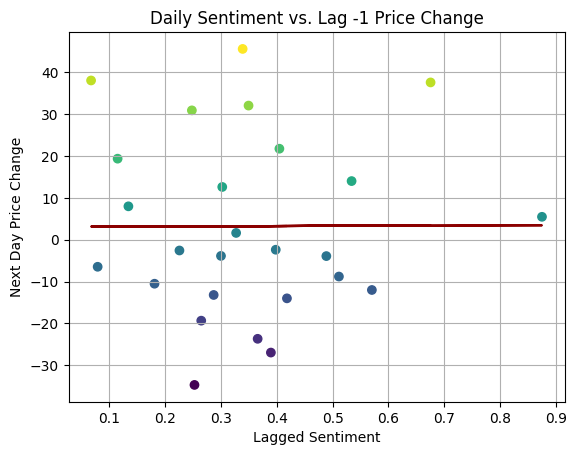

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with -1 Day(s) lag: 0.0
Linear Model R-squared: -0.26
Linear Model RMSE: 23.76

Average Price Change on High Sentiment Days: -35 %
Average Price Change on Low Sentiment Days: 686 %


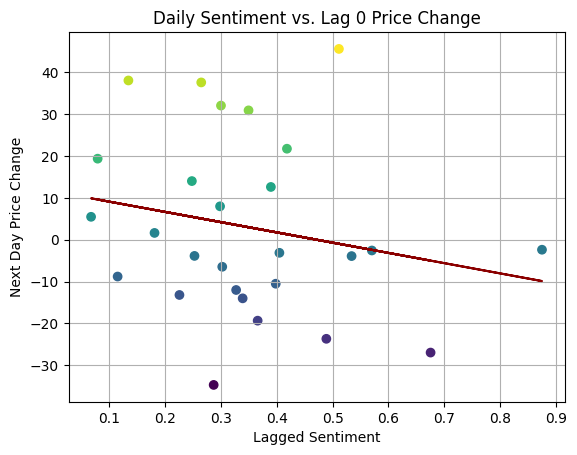

Correlation with 0 Day(s) lag: -0.21
Linear Model R-squared: -0.01
Linear Model RMSE: 22.24

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 551 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


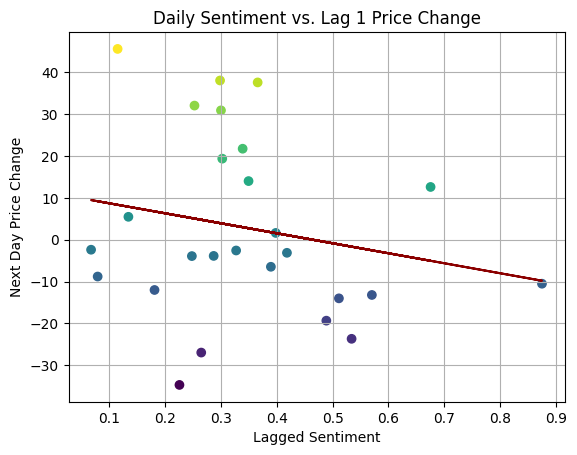

Correlation with 1 Day(s) lag: -0.2
Linear Model R-squared: -0.27
Linear Model RMSE: 28.52

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 532 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


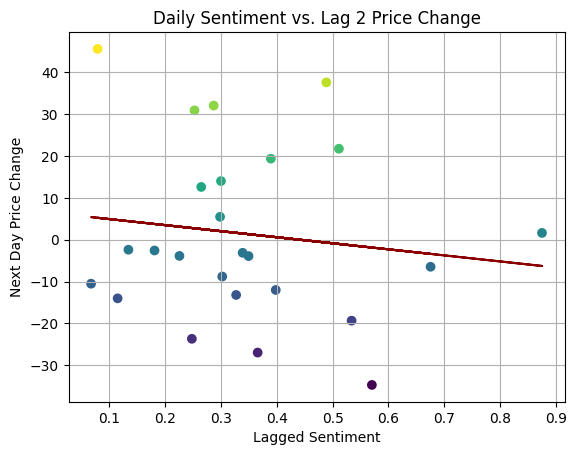

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 2 Day(s) lag: -0.13
Linear Model R-squared: -0.06
Linear Model RMSE: 21.23

Average Price Change on High Sentiment Days: 153 %
Average Price Change on Low Sentiment Days: 131 %
Skipping prediction due to NaN values in input


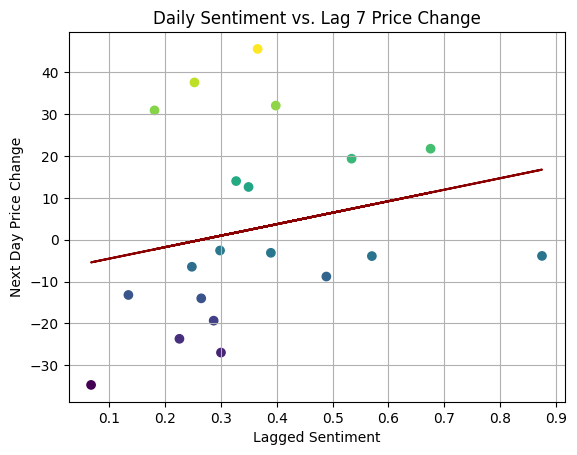

Correlation with 7 Day(s) lag: 0.23
Linear Model R-squared: -6.95
Linear Model RMSE: 19.55

Average Price Change on High Sentiment Days: 312 %
Average Price Change on Low Sentiment Days: 220 %


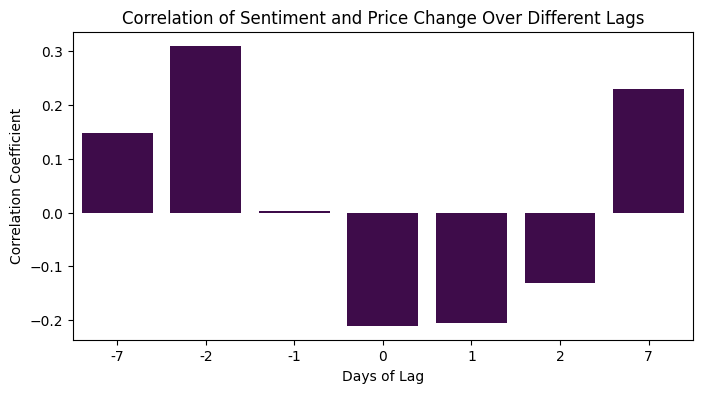

Average Prediction for lag 0: 3.56
Average Prediction for lag 1: 5.4
Average Prediction for lag 2: 4.32
Overall Average Prediction across all lags: 4.43


In [23]:
# Perform Analysis
from_date=30
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### Random Forest

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


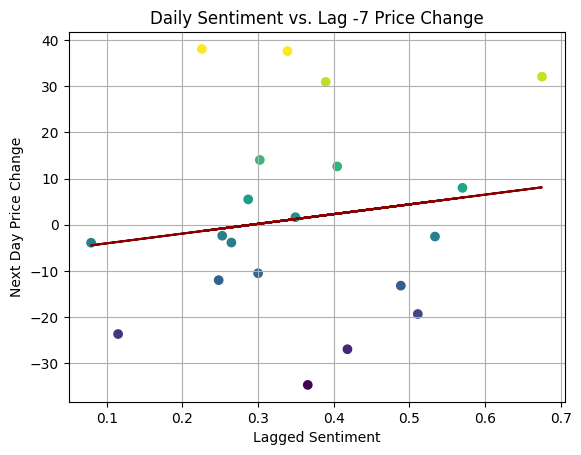

Correlation with -7 Day(s) lag: 0.15
Rf Model R-squared: -0.41
Rf Model RMSE: 30.2

Average Price Change on High Sentiment Days: -580 %
Average Price Change on Low Sentiment Days: 851 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


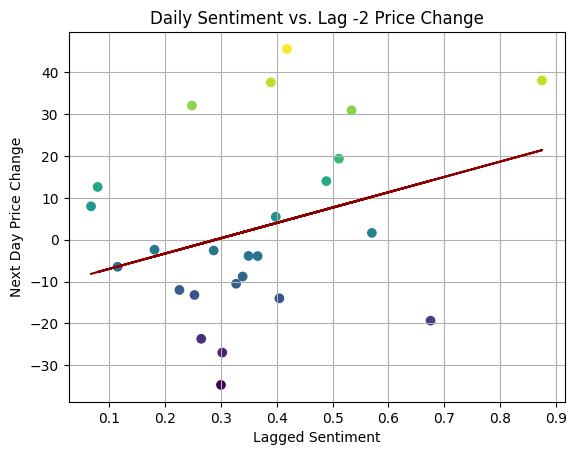

Correlation with -2 Day(s) lag: 0.31
Rf Model R-squared: -0.28
Rf Model RMSE: 30.16

Average Price Change on High Sentiment Days: -220 %
Average Price Change on Low Sentiment Days: 686 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


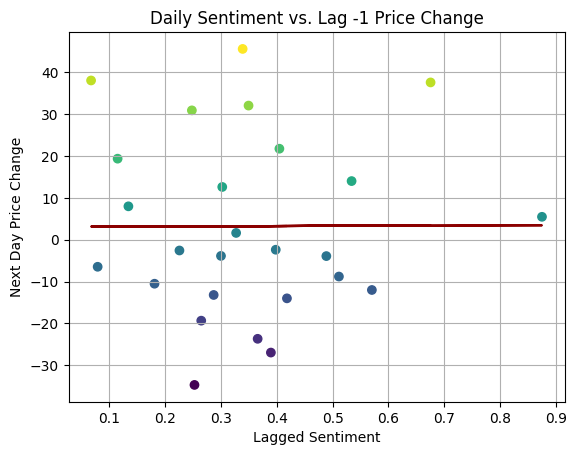

Correlation with -1 Day(s) lag: 0.0
Rf Model R-squared: -0.92
Rf Model RMSE: 29.36

Average Price Change on High Sentiment Days: -35 %
Average Price Change on Low Sentiment Days: 686 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


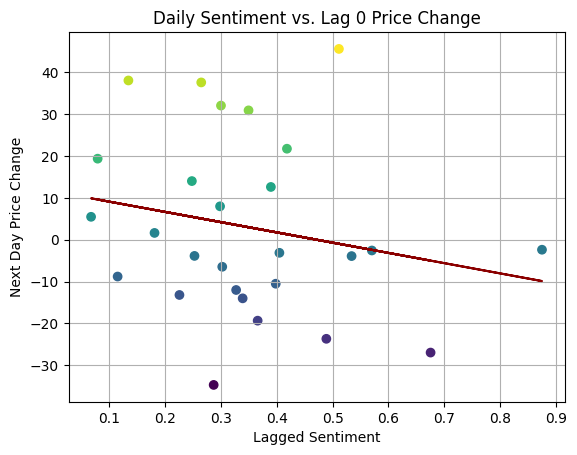

Correlation with 0 Day(s) lag: -0.21
Rf Model R-squared: -0.53
Rf Model RMSE: 27.3

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 551 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


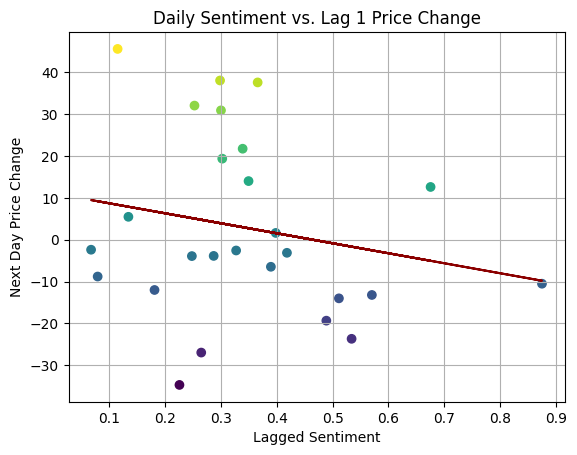

Correlation with 1 Day(s) lag: -0.2
Rf Model R-squared: -0.15
Rf Model RMSE: 27.08

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 532 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


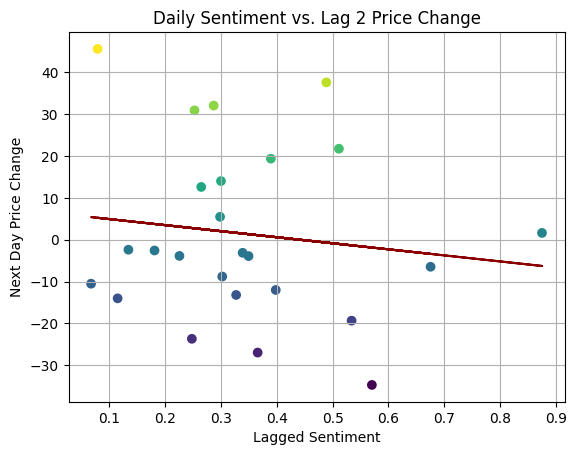

Correlation with 2 Day(s) lag: -0.13
Rf Model R-squared: -0.82
Rf Model RMSE: 27.85

Average Price Change on High Sentiment Days: 153 %
Average Price Change on Low Sentiment Days: 131 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


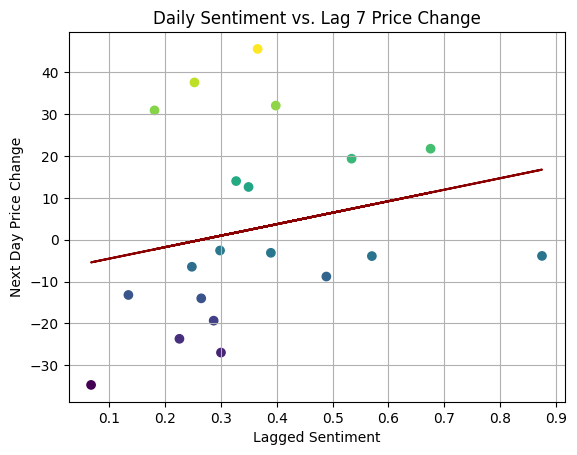

Correlation with 7 Day(s) lag: 0.23
Rf Model R-squared: -14.38
Rf Model RMSE: 27.19

Average Price Change on High Sentiment Days: 312 %
Average Price Change on Low Sentiment Days: 220 %


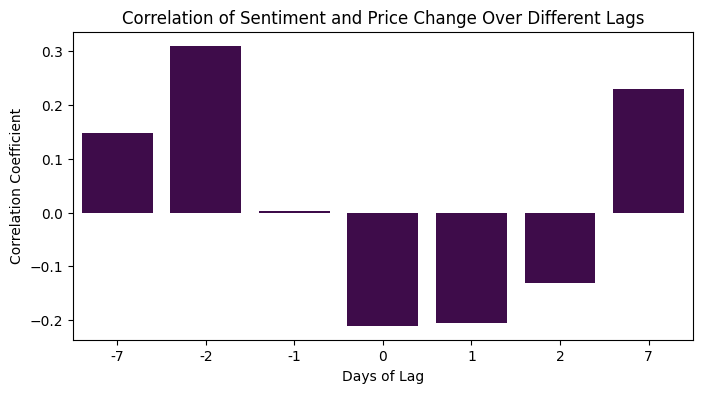

Average Prediction for lag 0: -5.75
Average Prediction for lag 1: 10.83
Average Prediction for lag 2: 6.56
Overall Average Prediction across all lags: 3.88


In [24]:
# Perform Analysis
from_date=30
model_type = 'rf'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### GBM

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


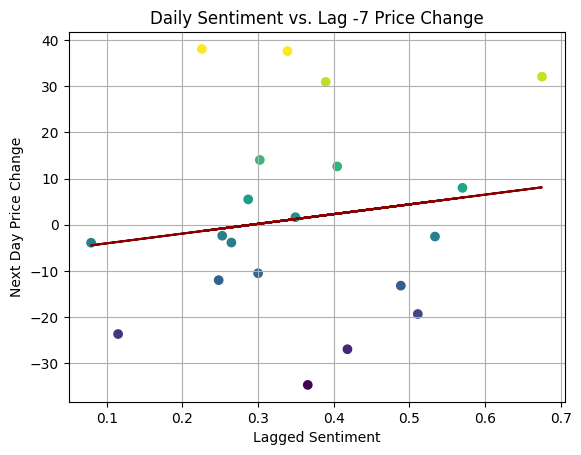

Correlation with -7 Day(s) lag: 0.15
Gbm Model R-squared: -0.33
Gbm Model RMSE: 29.33

Average Price Change on High Sentiment Days: -580 %
Average Price Change on Low Sentiment Days: 851 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


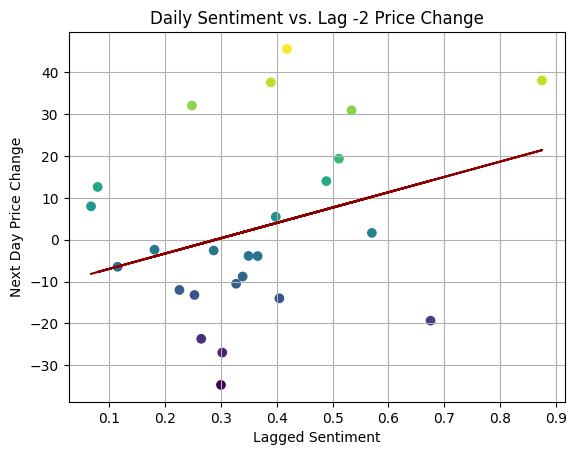

Correlation with -2 Day(s) lag: 0.31
Gbm Model R-squared: -0.45
Gbm Model RMSE: 32.14

Average Price Change on High Sentiment Days: -220 %
Average Price Change on Low Sentiment Days: 686 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


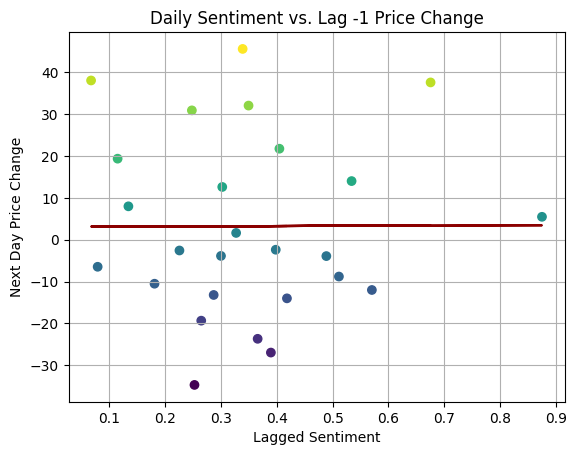

Correlation with -1 Day(s) lag: 0.0
Gbm Model R-squared: -1.7
Gbm Model RMSE: 34.79

Average Price Change on High Sentiment Days: -35 %
Average Price Change on Low Sentiment Days: 686 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


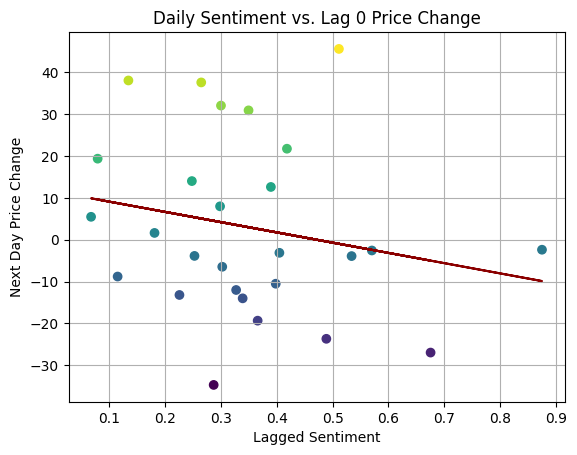

Correlation with 0 Day(s) lag: -0.21
Gbm Model R-squared: -0.58
Gbm Model RMSE: 27.77

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 551 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


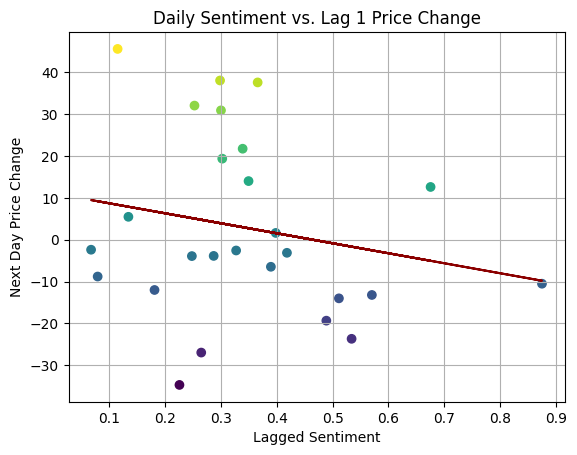

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 1 Day(s) lag: -0.2
Gbm Model R-squared: -0.6
Gbm Model RMSE: 32.01

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 532 %
Skipping prediction due to NaN values in input


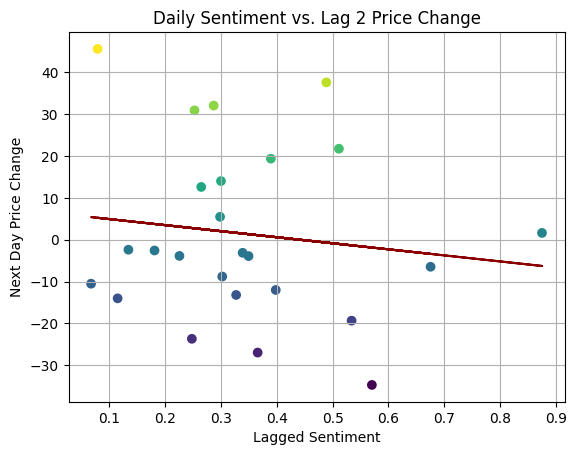

Correlation with 2 Day(s) lag: -0.13
Gbm Model R-squared: -1.43
Gbm Model RMSE: 32.19

Average Price Change on High Sentiment Days: 153 %
Average Price Change on Low Sentiment Days: 131 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


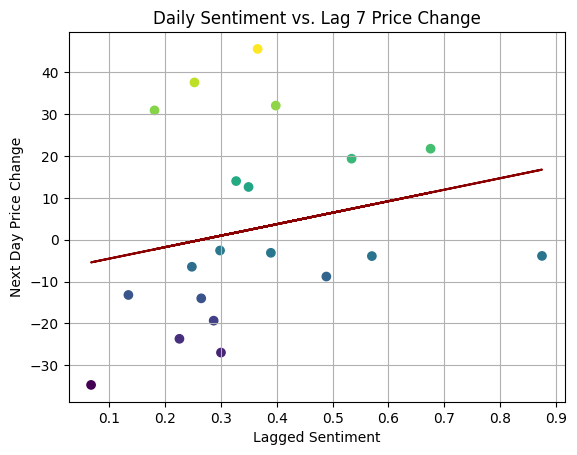

Correlation with 7 Day(s) lag: 0.23
Gbm Model R-squared: -24.16
Gbm Model RMSE: 34.78

Average Price Change on High Sentiment Days: 312 %
Average Price Change on Low Sentiment Days: 220 %


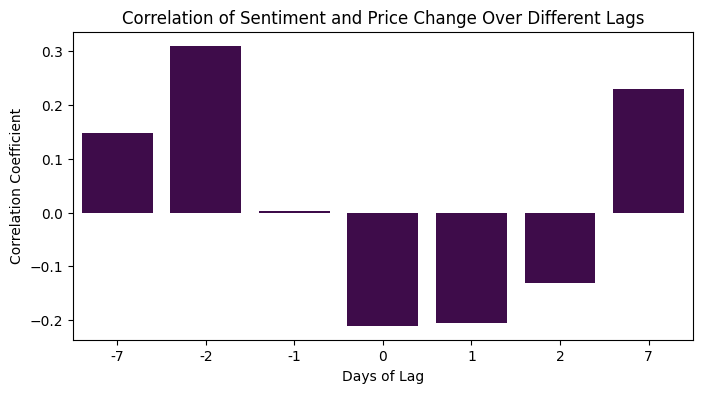

Average Prediction for lag 0: -12.59
Average Prediction for lag 1: 19.32
Average Prediction for lag 2: 7.98
Overall Average Prediction across all lags: 4.9


In [25]:
# Perform Analysis
from_date=30
model_type = 'gbm'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### SVR

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


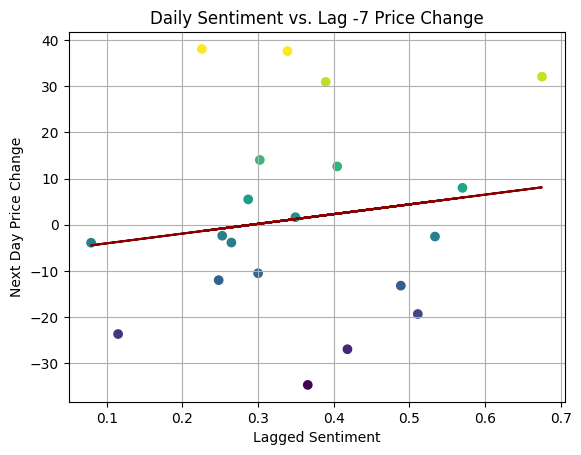

Correlation with -7 Day(s) lag: 0.15
Svr Model R-squared: -0.24
Svr Model RMSE: 28.26

Average Price Change on High Sentiment Days: -580 %
Average Price Change on Low Sentiment Days: 851 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


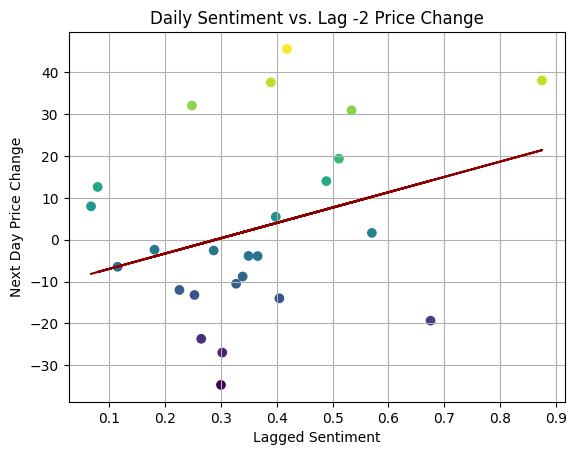

Correlation with -2 Day(s) lag: 0.31
Svr Model R-squared: -0.11
Svr Model RMSE: 28.08

Average Price Change on High Sentiment Days: -220 %
Average Price Change on Low Sentiment Days: 686 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


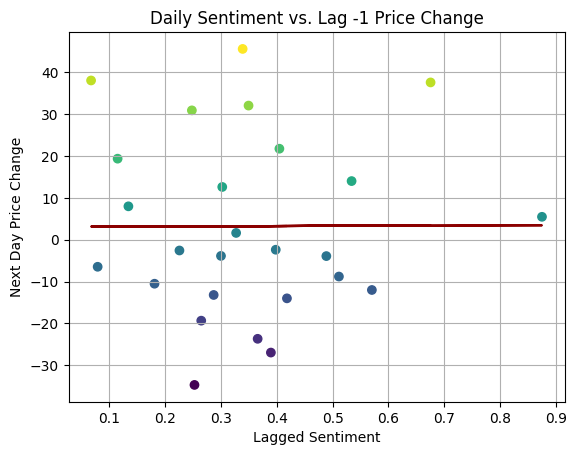

Correlation with -1 Day(s) lag: 0.0
Svr Model R-squared: -0.0
Svr Model RMSE: 21.18

Average Price Change on High Sentiment Days: -35 %
Average Price Change on Low Sentiment Days: 686 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


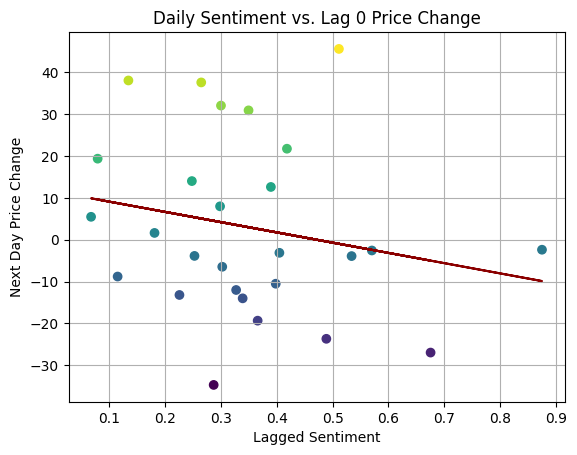

Correlation with 0 Day(s) lag: -0.21
Svr Model R-squared: -0.02
Svr Model RMSE: 22.29

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 551 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Skipping prediction due to NaN values in input


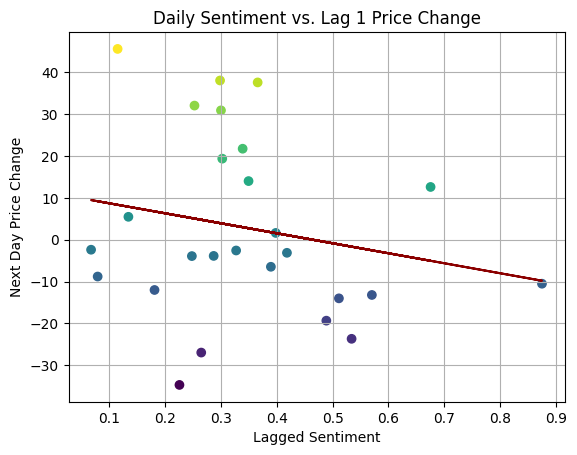

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 1 Day(s) lag: -0.2
Svr Model R-squared: -0.47
Svr Model RMSE: 30.68

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 532 %
Skipping prediction due to NaN values in input


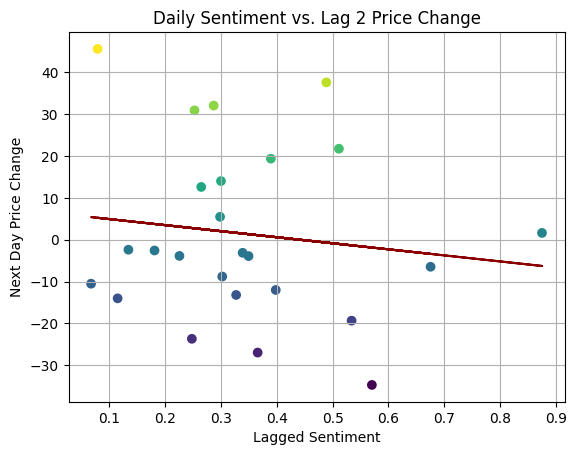

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 2 Day(s) lag: -0.13
Svr Model R-squared: -0.11
Svr Model RMSE: 21.74

Average Price Change on High Sentiment Days: 153 %
Average Price Change on Low Sentiment Days: 131 %
Skipping prediction due to NaN values in input


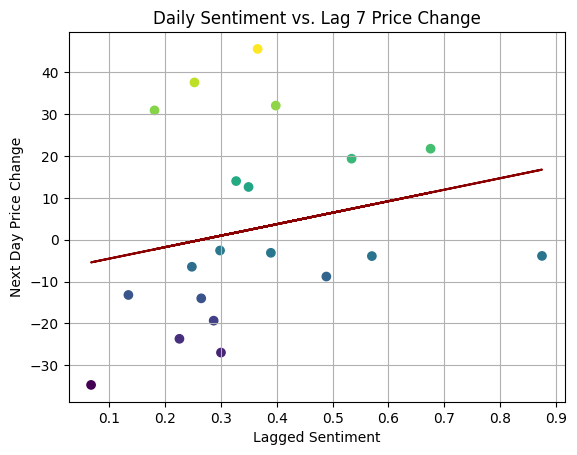

Correlation with 7 Day(s) lag: 0.23
Svr Model R-squared: -13.06
Svr Model RMSE: 26.0

Average Price Change on High Sentiment Days: 312 %
Average Price Change on Low Sentiment Days: 220 %


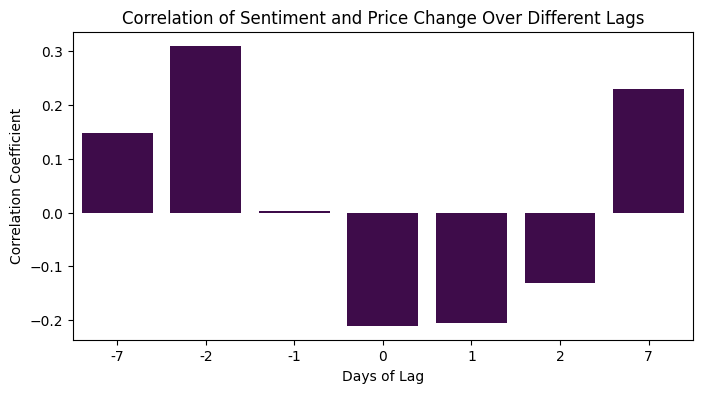

Average Prediction for lag 0: -1.59
Average Prediction for lag 1: -2.27
Average Prediction for lag 2: -2.64
Overall Average Prediction across all lags: -2.17


In [26]:
# Perform Analysis
from_date=30
model_type = 'svr'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

## Daily

2024-05-04 00:00:00 2024-05-06 00:00:00


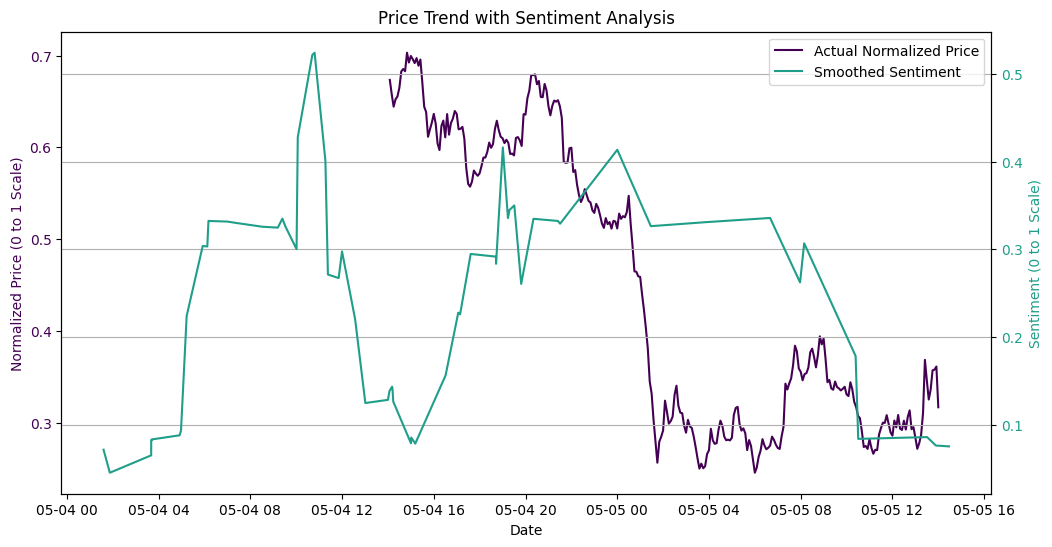

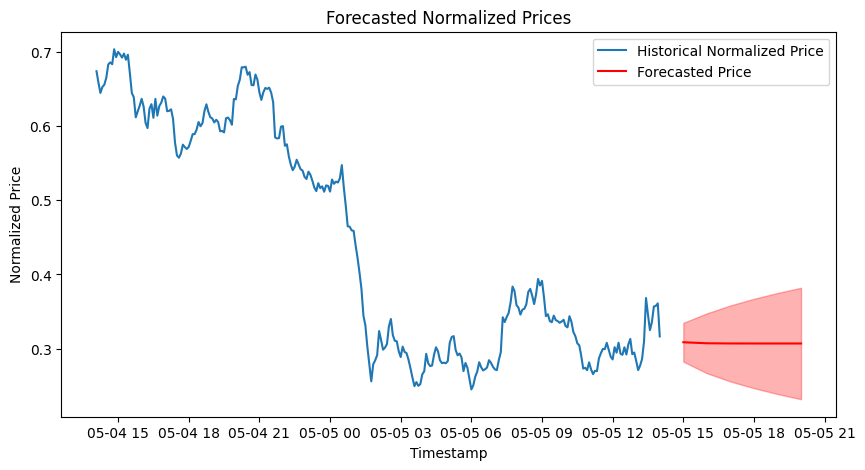

{'average_change_percent': -2.898256126204684, 'average_ci_lower_percent': -19.777680868309293, 'average_ci_upper_percent': 13.981168615899923, 'rmse': 0.20458464280364036}


In [27]:
#for testing purposes
sentiment_data = pd.read_csv(f"data/2024-04-05_24h_news_with_sentiment.csv")
price_data = pd.read_csv('data/2024-04-05_24h_50meme_history.csv')
from_date = 0
end = hd.get_date_dt(18)
start = hd.get_date_dt(19.5)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())
vz.window_size = 7
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end=end, start=start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)

averages_forecasts, plot = vz.forecast_prices_with_arima(price_data, forecast_periods=6, for_web=False)
print(averages_forecasts)

# Calculate percentage price change directly from normalized prices
price_data['price_change'] = price_data['normalized price'].pct_change() * 100
price_data['price_change'] = price_data['price_change'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Resample price data to 5-minute intervals, forward filling the last known prices and changes
price_data_resampled = price_data.resample('5min').last().ffill()

# Round sentiment data timestamps to the nearest 5 minutes
sentiment_data.index = sentiment_data.index.round('5min')

# Merge using merge_asof to align sentiment data with the nearest price data
combined_data = pd.merge_asof(sentiment_data.sort_index(), price_data_resampled.reset_index(), 
                              left_index=True, right_on='timestamp', direction='forward')

# Since we need the next period's price change, shift the 'price_change' column by -1
combined_data['Next 5min Price Change'] = combined_data['price_change'].shift(-1)

# Rename columns to match function expectations
combined_data.rename(columns={'Average Sentiment': 'Average Sentiment'}, inplace=True)

# Drop the 'timestamp' and original 'price_change' columns if not needed
combined_data.drop(columns=['timestamp', 'price_change'], inplace=True)

### Linear

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


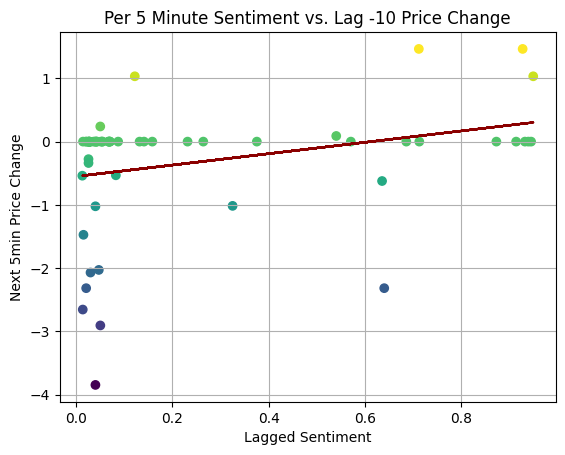

Correlation with -10 5min(s) lag: 0.29
Linear Model R-squared: -0.4
Linear Model RMSE: 0.64

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -18 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


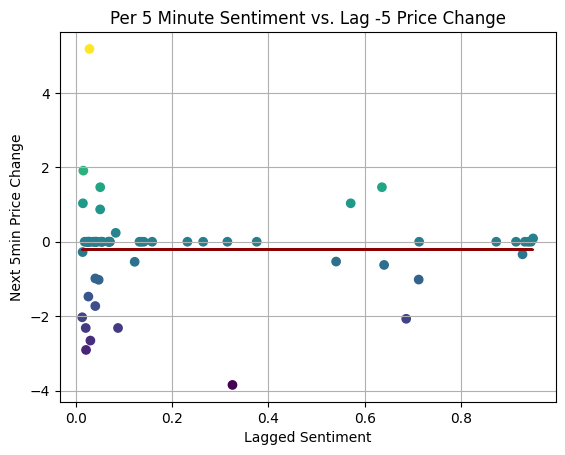

Correlation with -5 5min(s) lag: 0.0
Linear Model R-squared: -0.04
Linear Model RMSE: 1.68

Average Price Change on High Sentiment 5mins: -46 %
Average Price Change on Low Sentiment 5mins: 2 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


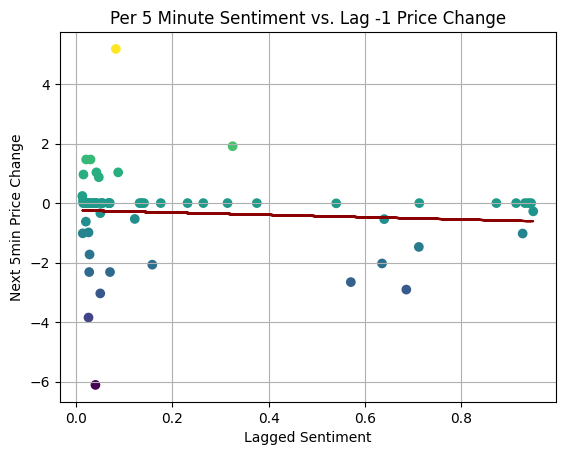

Correlation with -1 5min(s) lag: -0.08
Linear Model R-squared: -0.16
Linear Model RMSE: 1.11

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


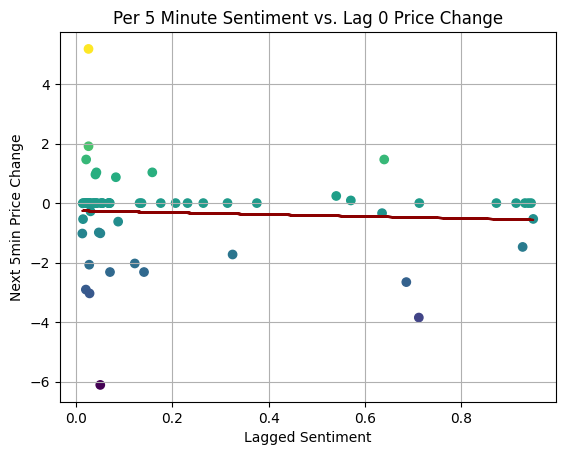

Correlation with 0 5min(s) lag: -0.07
Linear Model R-squared: -0.21
Linear Model RMSE: 1.14

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


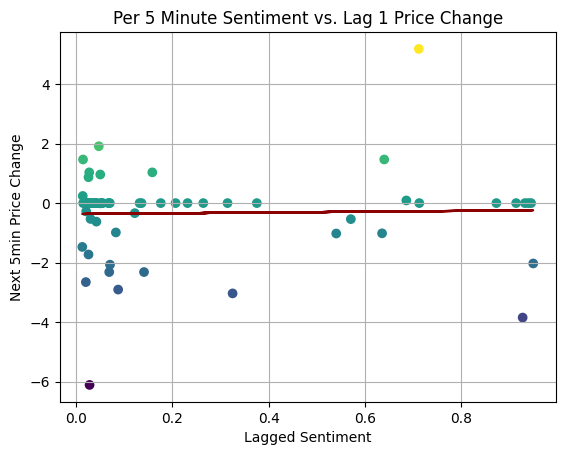

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 1 5min(s) lag: 0.03
Linear Model R-squared: -0.04
Linear Model RMSE: 1.91

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -23 %
Skipping prediction due to NaN values in input


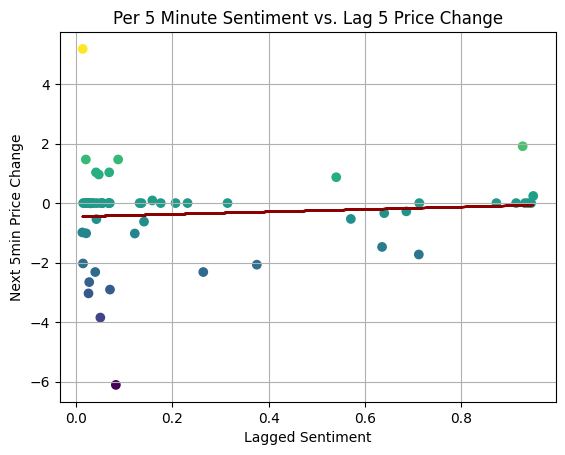

Correlation with 5 5min(s) lag: 0.08
Linear Model R-squared: -0.02
Linear Model RMSE: 1.9

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -25 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


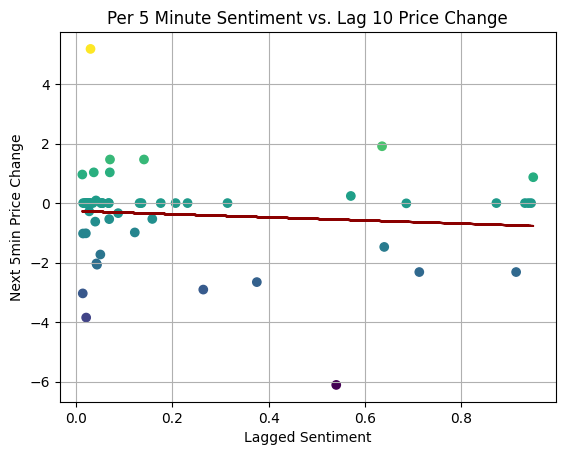

Correlation with 10 5min(s) lag: -0.1
Linear Model R-squared: -0.36
Linear Model RMSE: 1.4

Average Price Change on High Sentiment 5mins: -52 %
Average Price Change on Low Sentiment 5mins: -26 %


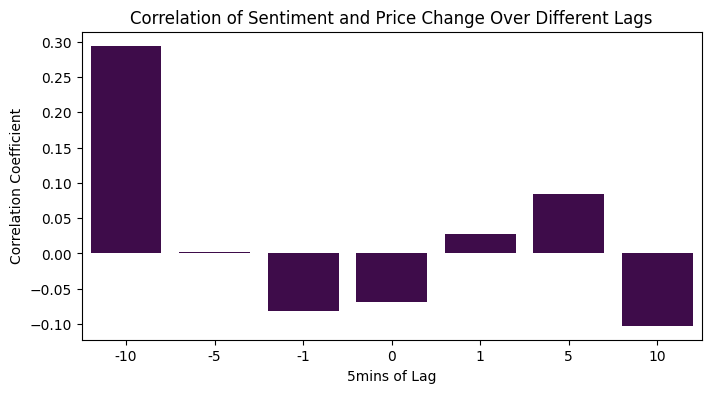

Average Prediction for lag 0: -0.41
Average Prediction for lag 1: -0.35
Overall Average Prediction across all lags: -0.38


In [28]:
# Perform Analysis
from_date=1
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### Random Forest

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


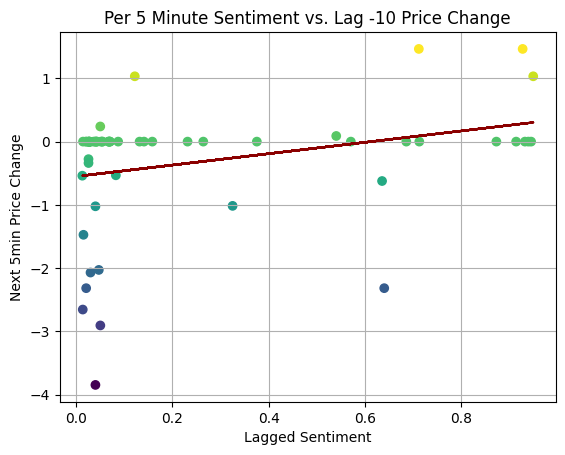

Correlation with -10 5min(s) lag: 0.29
Rf Model R-squared: -1.65
Rf Model RMSE: 0.88

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -18 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


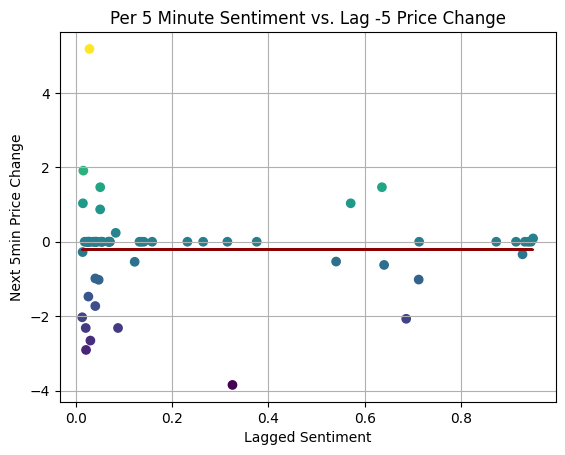

Correlation with -5 5min(s) lag: 0.0
Rf Model R-squared: -0.2
Rf Model RMSE: 1.8

Average Price Change on High Sentiment 5mins: -46 %
Average Price Change on Low Sentiment 5mins: 2 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


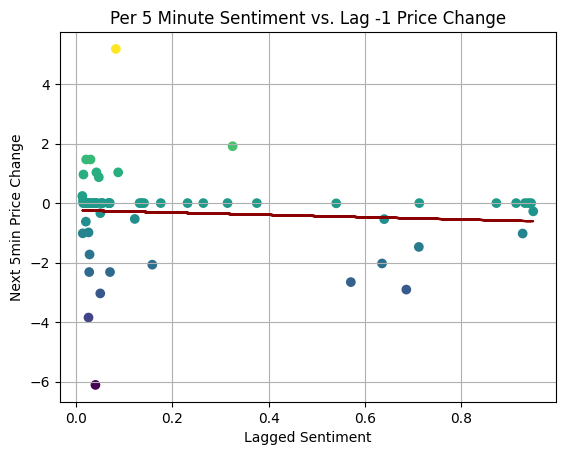

Correlation with -1 5min(s) lag: -0.08
Rf Model R-squared: -0.22
Rf Model RMSE: 1.14

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


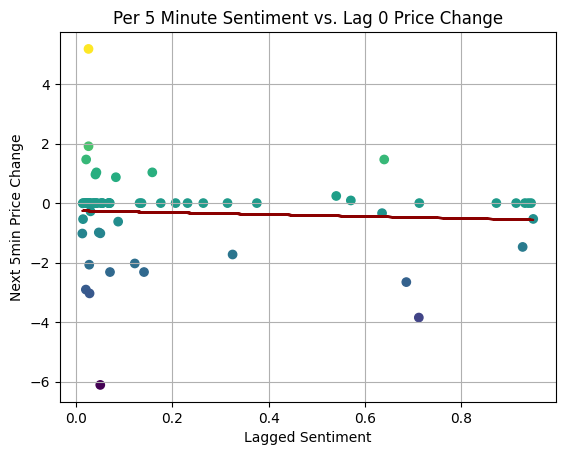

Correlation with 0 5min(s) lag: -0.07
Rf Model R-squared: -0.92
Rf Model RMSE: 1.43

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


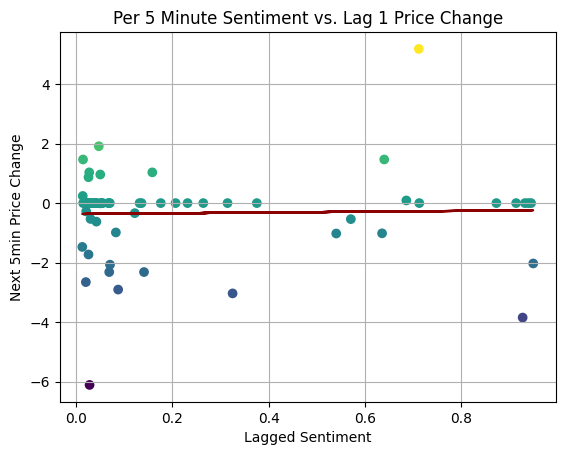

Correlation with 1 5min(s) lag: 0.03
Rf Model R-squared: -0.27
Rf Model RMSE: 2.11

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -23 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


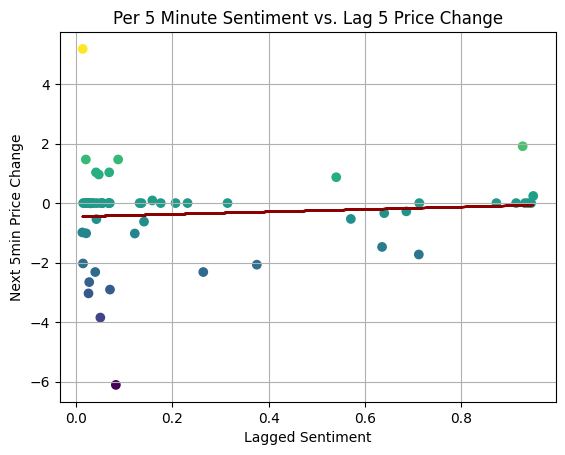

Correlation with 5 5min(s) lag: 0.08
Rf Model R-squared: -0.38
Rf Model RMSE: 2.21

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -25 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


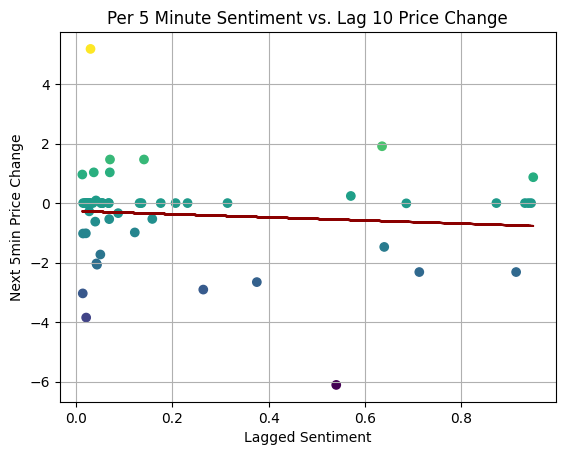

Correlation with 10 5min(s) lag: -0.1
Rf Model R-squared: -1.41
Rf Model RMSE: 1.86

Average Price Change on High Sentiment 5mins: -52 %
Average Price Change on Low Sentiment 5mins: -26 %


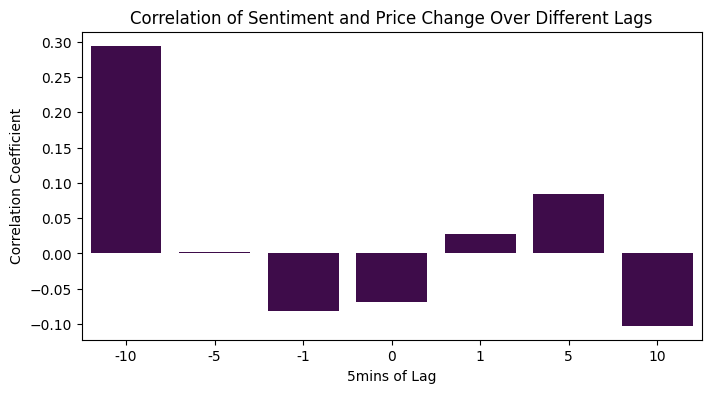

Average Prediction for lag 0: -2.67
Average Prediction for lag 1: -1.04
Overall Average Prediction across all lags: -1.86


In [29]:
# Perform Analysis
from_date=1
model_type = 'rf'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### GBM

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


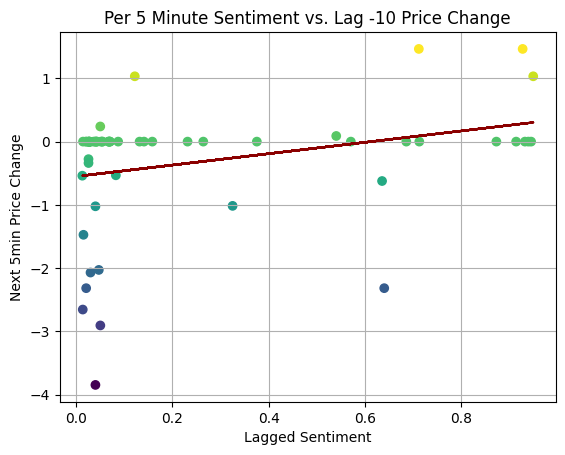

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with -10 5min(s) lag: 0.29
Gbm Model R-squared: -3.9
Gbm Model RMSE: 1.2

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -18 %
Skipping prediction due to NaN values in input


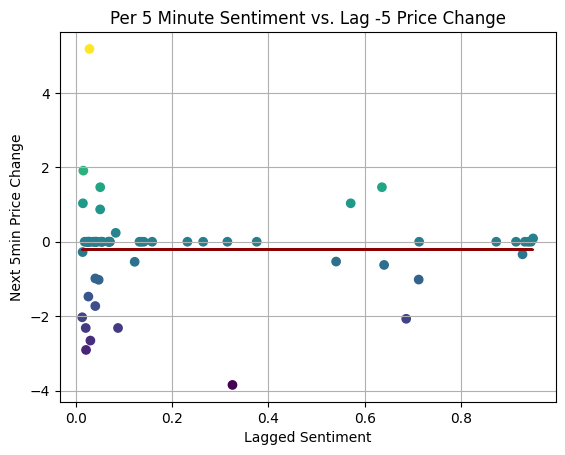

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with -5 5min(s) lag: 0.0
Gbm Model R-squared: -0.31
Gbm Model RMSE: 1.88

Average Price Change on High Sentiment 5mins: -46 %
Average Price Change on Low Sentiment 5mins: 2 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


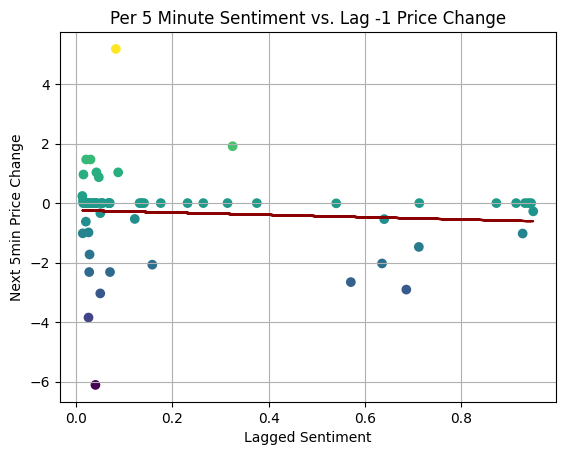

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Correlation with -1 5min(s) lag: -0.08
Gbm Model R-squared: -0.5
Gbm Model RMSE: 1.26

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %


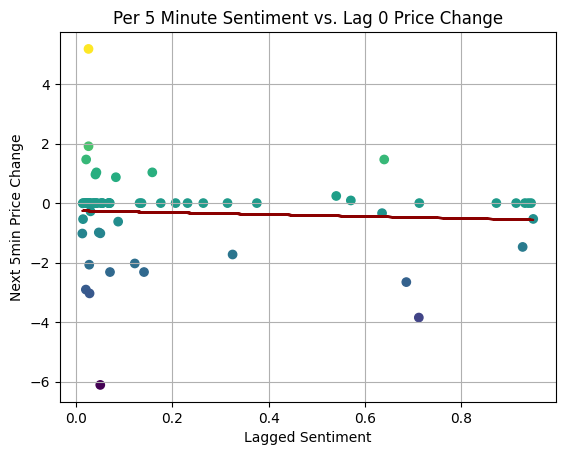

Correlation with 0 5min(s) lag: -0.07
Gbm Model R-squared: -1.23
Gbm Model RMSE: 1.54

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


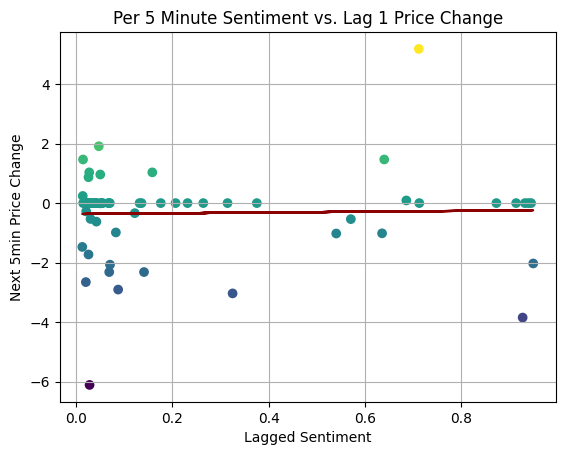

Correlation with 1 5min(s) lag: 0.03
Gbm Model R-squared: -0.48
Gbm Model RMSE: 2.29

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -23 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Skipping prediction due to NaN values in input


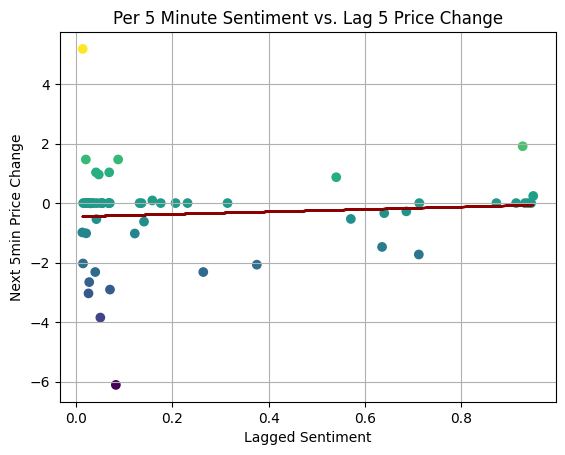

Correlation with 5 5min(s) lag: 0.08
Gbm Model R-squared: -0.56
Gbm Model RMSE: 2.35

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -25 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Skipping prediction due to NaN values in input


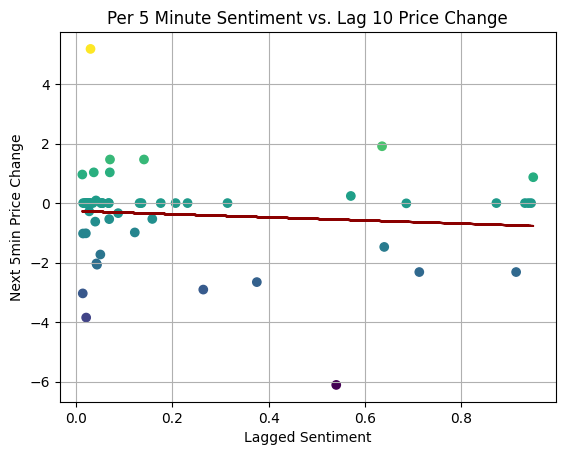

Correlation with 10 5min(s) lag: -0.1
Gbm Model R-squared: -2.36
Gbm Model RMSE: 2.2

Average Price Change on High Sentiment 5mins: -52 %
Average Price Change on Low Sentiment 5mins: -26 %


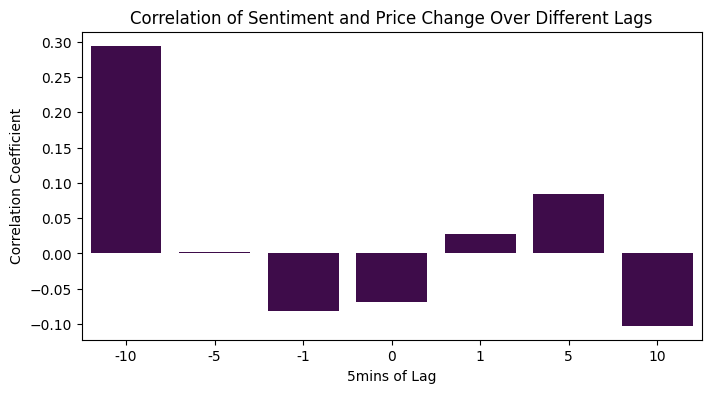

Average Prediction for lag 0: -4.0
Average Prediction for lag 1: -1.39
Overall Average Prediction across all lags: -2.69


In [30]:
# Perform Analysis
from_date=1
model_type = 'gbm'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

### SVR

Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


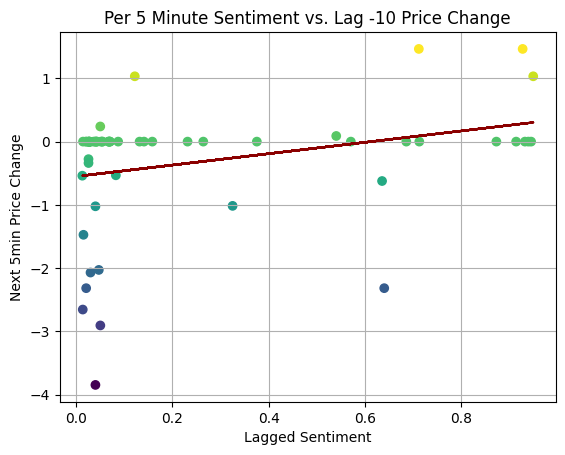

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with -10 5min(s) lag: 0.29
Gbm Model R-squared: -3.9
Gbm Model RMSE: 1.2

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -18 %
Skipping prediction due to NaN values in input


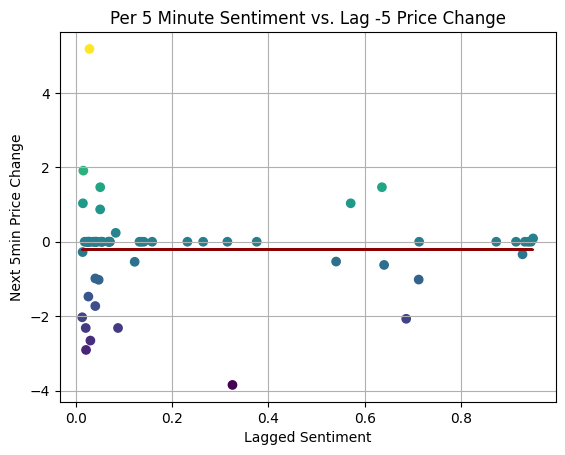

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Correlation with -5 5min(s) lag: 0.0
Gbm Model R-squared: -0.31
Gbm Model RMSE: 1.88

Average Price Change on High Sentiment 5mins: -46 %
Average Price Change on Low Sentiment 5mins: 2 %


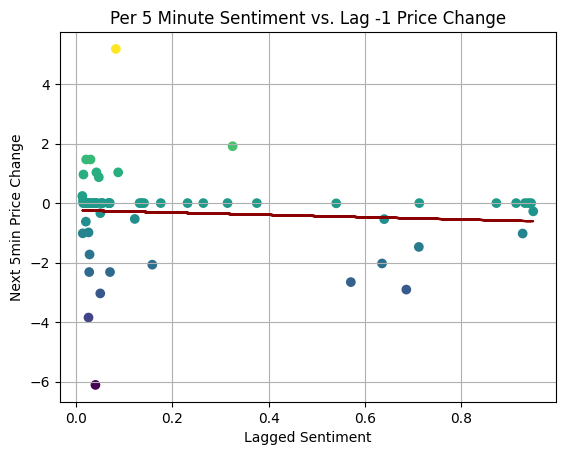

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Correlation with -1 5min(s) lag: -0.08
Gbm Model R-squared: -0.5
Gbm Model RMSE: 1.26

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %


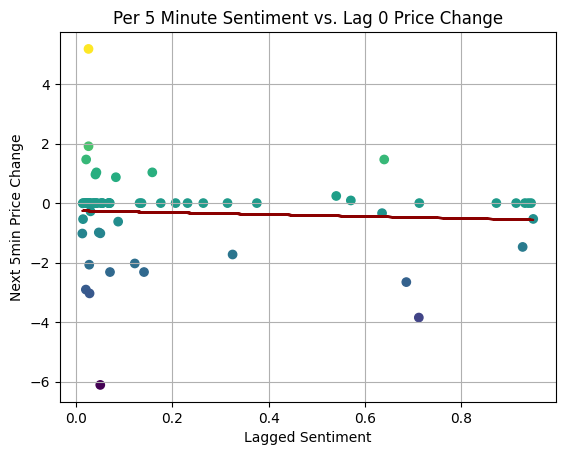

Correlation with 0 5min(s) lag: -0.07
Gbm Model R-squared: -1.23
Gbm Model RMSE: 1.54

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %
Skipping prediction due to NaN values in input


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


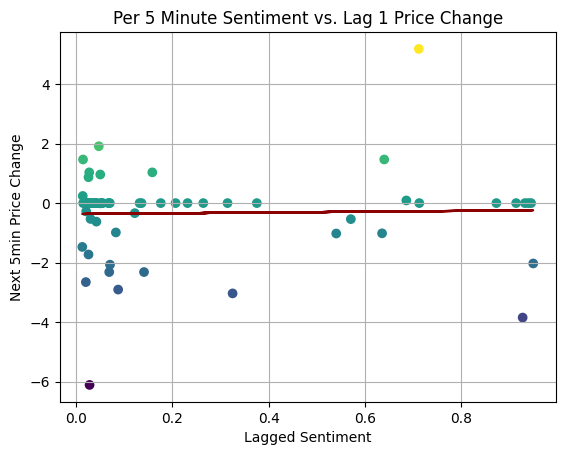

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Correlation with 1 5min(s) lag: 0.03
Gbm Model R-squared: -0.48
Gbm Model RMSE: 2.29

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -23 %
Skipping prediction due to NaN values in input


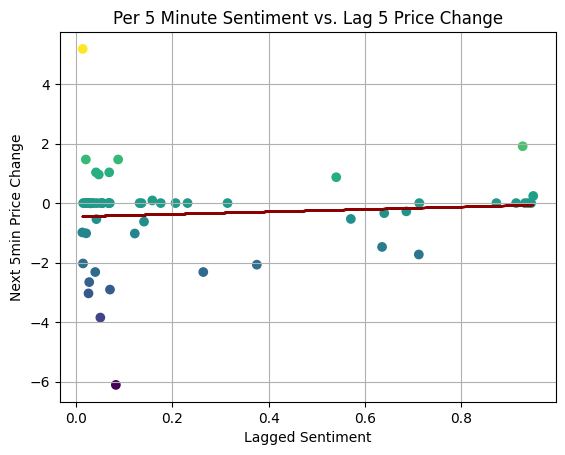

Correlation with 5 5min(s) lag: 0.08
Gbm Model R-squared: -0.56
Gbm Model RMSE: 2.35

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -25 %


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_9356\1744834098.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


Skipping prediction due to NaN values in input


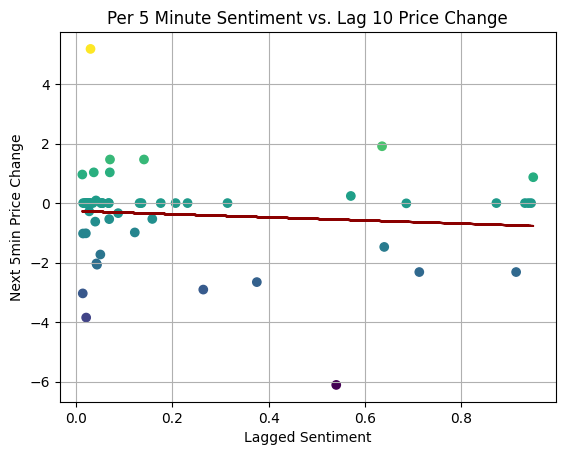

Correlation with 10 5min(s) lag: -0.1
Gbm Model R-squared: -2.36
Gbm Model RMSE: 2.2

Average Price Change on High Sentiment 5mins: -52 %
Average Price Change on Low Sentiment 5mins: -26 %


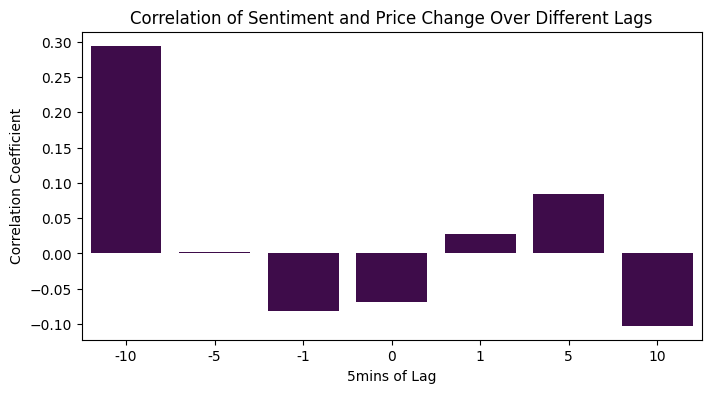

Average Prediction for lag 0: -4.0
Average Prediction for lag 1: -1.39
Overall Average Prediction across all lags: -2.69


In [34]:
# Perform Analysis
from_date=1
model_type = 'gbm'  # or 'rf'
future_predictions_by_lag = analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")